<a href="https://colab.research.google.com/github/ldocarvalho/portals-bias/blob/main/portals_bias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. Data

In [9]:
import pandas as pd

In [10]:
df_names = ["Source", "Title", "Content", "Bias"]

In [11]:
df_news_july = pd.read_csv('https://raw.githubusercontent.com/ldocarvalho/portals-bias/main/Dataset/News-July-19/news-july.csv?token=AKX52J5KQ3NIC6K7PWM7XPLBYDNKA', names = df_names, skiprows = 1, header = None)
df_news_july

,Source,Title,Content,Bias
0,berkeleyside,"ArchivesJune 10, 2019",When the homeowner did not voluntarily repair ...,left-center
1,berkeleyside,Berkeley homeowner caught in costly code viola...,"Finger-pointing, confusion, worry and mistrust...",left-center
2,berkeleyside,"A small-business success story, Yalis Caf cele...","Yali's Caf 1920 Oxford St. (at Berkeley Way), ...",left-center
3,berkeleyside,Shop Talk: Bluemercury; Airport Home Appliance...,BLUEMERCURY A new business is opening in the o...,left-center
4,berkeleyside,New vision plan imagines 3-mile greenway from ...,Imagine a bike and pedestrian path stretching ...,left-center
...,...,...,...,...
4955,theblaze,Bill Cosbys official Instagram account shares ...,The official Instagram account of actor Bill C...,right
4956,theblaze,WATCH: Students condemn racist remarks they be...,Students at Marymount University in Virginia b...,right
4957,theblaze,Republicans propose constitutional amendment t...,President Donald Trump is supporting a propose...,right
4958,theblaze,108 GOP lawmakers sign letter asking Trump to ...,More than a hundred Republican members of Cong...,right


In [12]:
df_news_february = pd.read_csv('https://raw.githubusercontent.com/vicaires/News-Media-Bias-Datasets/main/Text-based%20datasets/News-February-20/news-february.csv', names = df_names, skiprows = 1, header = None)
df_news_february

,Source,Title,Content,Bias
0,motherjones.com,Terms of Service,Welcome to the Mother Jones website. Please re...,left-center
1,motherjones.com,The Enormous but Hidden Consequences of Antarc...,This story was originally published by Wired a...,left-center
2,motherjones.com,Mother Jones Logo (Orange) Women's Fitted Tee,motherjones-logoorange-wtee-white-sm $20.00 Mo...,left-center
3,motherjones.com,A Fucking Disaster That Is Designed to Fail: H...,"SAN DIEGO IMMIGRATION COURT, COURTROOM #2; PRE...",left-center
4,motherjones.com,Privacy Policy,The MotherJones.com website is operated by the...,left-center
...,...,...,...,...
11515,punchingbagpost.com,"Trump Reverses Obama, Hands Farmers, Landowner...","tml> Trump Reverses Obama, Hands Farmers, Land...",right-center
11516,punchingbagpost.com,Russia Germany Dispute Could Trigger Trade War,You Might Like German lawmakers are calling to...,right-center
11517,punchingbagpost.com,Bloomberg is Still Trying to Buy the Election ...,"In less than three months, Democratic presiden...",right-center
11518,punchingbagpost.com,Everything China Told us About the Coronavirus...,"For weeks, officials throughout the world assu...",right-center


### 2. Text Pre-processing

In [13]:
def to_lower(text):
  return text.lower()

In [14]:
import re

def remove_numbers(text):
  return re.sub(r'\d+', '', text)

In [15]:
import string
import numpy as np

def remove_puctuation(text):
  symbols = "!\"#$%&()'*+-.,—/:;<=>?@[\]^_`{|}~\n“‘"
  for i in symbols:
    text = text.replace(i, '')
  return text

In [16]:
def preprocess(data):
    data = to_lower(data)
    data = remove_puctuation(data)
    data = remove_numbers(data)
    return data

### 3. Classification Utils

In [17]:
pip install -U scikit-learn

In [18]:
from numpy import mean
from numpy import std

from sklearn import preprocessing
from sklearn.svm import SVC

from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
def grid_search_cv_with_svm(X, y):
  model = GridSearchCV(SVC(kernel='rbf'), {
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': ['auto', 'scale'],
  }, cv=10, n_jobs=-1)

  model.fit(X, y)
  df_results = pd.DataFrame(model.cv_results_)
  print(df_results[['param_C', 'param_gamma', 'mean_test_score']])

In [20]:
from sklearn.metrics import classification_report, accuracy_score, make_scorer

def classification_with_svm(X, y, gamma, c, k):
  original_class = []
  predicted_class = []

  def classification_report_with_accuracy(y_true, y_pred):
    original_class.extend(y_true)
    predicted_class.extend(y_pred)
    return accuracy_score(y_true, y_pred) 

  model = SVC(kernel='rbf', gamma=gamma, C=c)
  score = cross_val_score(model, X = X, y = y, cv = k, scoring = make_scorer(classification_report_with_accuracy))

  print(classification_report(original_class, predicted_class))

  labels_class = ['Esquerda', 'Direita']
  data = confusion_matrix(original_class, predicted_class, normalize='true')
  df_cm = pd.DataFrame(data, columns=labels_class, index=labels_class)
  df_cm.index.name = 'Real'
  df_cm.columns.name = 'Predito'
  plt.figure(figsize = (7,5))
  sns.set(font_scale=1.0)
  sns.heatmap(df_cm, annot=True, cmap='coolwarm', fmt=".2f")
  plt.plot()

In [21]:
def classification_with_svm_4_classes(X, y, gamma, c, k):
  original_class = []
  predicted_class = []

  def classification_report_with_accuracy(y_true, y_pred):
    original_class.extend(y_true)
    predicted_class.extend(y_pred)
    return accuracy_score(y_true, y_pred) 

  model = SVC(kernel='rbf', gamma=gamma, C=c)
  score = cross_val_score(model, X = X, y = y, cv = k, scoring = make_scorer(classification_report_with_accuracy))

  print(classification_report(original_class, predicted_class))

  labels_class = ['Centro-Esquerda', 'Esquerda', 'Direita', 'Centro-Direita']
  data = confusion_matrix(original_class, predicted_class, normalize='true')
  df_cm = pd.DataFrame(data, columns=labels_class, index=labels_class)
  df_cm.index.name = 'Real'
  df_cm.columns.name = 'Predito'
  plt.figure(figsize = (7,5))
  sns.set(font_scale=1.0)
  sns.heatmap(df_cm, annot=True, cmap='coolwarm', fmt=".2f")
  plt.plot()

### 4. Readability approach 

#### News July - Readability Features per News (Left, Right)

In [ ]:
df_readability_names = ["flesch-kincaid", "flesch-reading-ease", "dale-chall", "gunning-fog", "bias"]
df_readability = pd.DataFrame(columns = df_readability_names)
df_readability

,flesch-kincaid,flesch-reading-ease,dale-chall,gunning-fog,bias


In [ ]:
import textstat

for value in df_news_july.values:
  bias = ""
  if "left" in value[3]:
    bias = "left"
  else:
    bias = "right"
  content = preprocess(value[2])
  flesch_kincaid = textstat.flesch_kincaid_grade(content)
  flesch_reading = textstat.flesch_reading_ease(content)
  dale_chall = textstat.dale_chall_readability_score(content)
  gunning_fog = textstat.gunning_fog(content)
  df_readability = df_readability.append({"flesch-kincaid": flesch_kincaid, "flesch-reading-ease": flesch_reading, "dale-chall": dale_chall, "gunning-fog": gunning_fog, "bias": bias}, ignore_index=True)
df_readability

,flesch-kincaid,flesch-reading-ease,dale-chall,gunning-fog,bias
0,15.0,35.61,9.07,18.21,left
1,1038.0,-2615.91,138.35,1064.84,left
2,495.5,-1198.63,69.56,509.25,left
3,458.4,-1107.62,65.46,470.74,left
4,737.7,-1834.36,100.65,757.69,left
...,...,...,...,...,...
4955,119.9,-226.60,22.80,124.11,right
4956,135.5,-267.20,24.15,139.61,right
4957,110.2,-206.64,21.09,113.10,right
4958,119.9,-232.02,22.80,122.94,right


In [ ]:
y = df_readability['bias']

##### 1 feature

###### Flesch-Kincaid

In [ ]:
X_1 = df_readability.drop(['flesch-reading-ease', 'dale-chall', 'gunning-fog', 'bias'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_1, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.509073
1    0.01       scale         0.540726
2     0.1        auto         0.516331
3     0.1       scale         0.537903
4       1        auto         0.517944
5       1       scale         0.536492
6      10        auto         0.516331
7      10       scale         0.533669
8     100        auto         0.509274
9     100       scale         0.528831


In [ ]:
# C = 0.01, gamma = scale

              precision    recall  f1-score   support

        left       0.57      0.33      0.42      2480
       right       0.53      0.75      0.62      2480

    accuracy                           0.54      4960
   macro avg       0.55      0.54      0.52      4960
weighted avg       0.55      0.54      0.52      4960



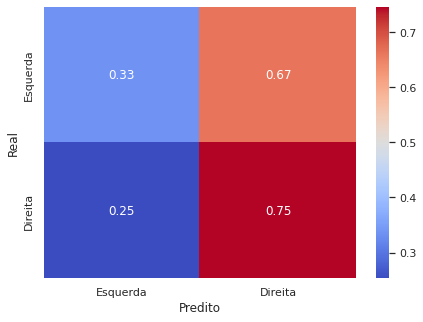

In [ ]:
classification_with_svm(X_1, y, 'scale', 0.01, 10)

###### Flesch reading ease

In [ ]:
X_2 = df_readability.drop(['flesch-kincaid', 'dale-chall', 'gunning-fog', 'bias'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_2, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.522379
1    0.01       scale         0.541331
2     0.1        auto         0.522379
3     0.1       scale         0.537500
4       1        auto         0.530847
5       1       scale         0.535484
6      10        auto         0.518750
7      10       scale         0.535282
8     100        auto         0.508266
9     100       scale         0.530645


In [ ]:
# C = 0.01, gamma = scale

              precision    recall  f1-score   support

        left       0.57      0.34      0.42      2480
       right       0.53      0.75      0.62      2480

    accuracy                           0.54      4960
   macro avg       0.55      0.54      0.52      4960
weighted avg       0.55      0.54      0.52      4960



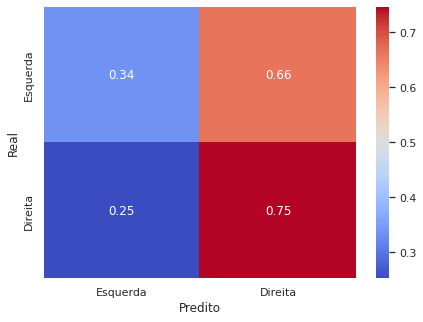

In [ ]:
classification_with_svm(X_2, y, 'scale', 0.01, 10)

###### Dale-Chall 

In [ ]:
X_3 = df_readability.drop(['flesch-kincaid', 'flesch-reading-ease', 'gunning-fog', 'bias'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_3, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.522984
1    0.01       scale         0.541532
2     0.1        auto         0.511492
3     0.1       scale         0.538105
4       1        auto         0.522581
5       1       scale         0.534879
6      10        auto         0.521774
7      10       scale         0.535685
8     100        auto         0.528831
9     100       scale         0.530847


In [ ]:
# C = 0.01, gamma = scale

              precision    recall  f1-score   support

        left       0.57      0.33      0.42      2480
       right       0.53      0.75      0.62      2480

    accuracy                           0.54      4960
   macro avg       0.55      0.54      0.52      4960
weighted avg       0.55      0.54      0.52      4960



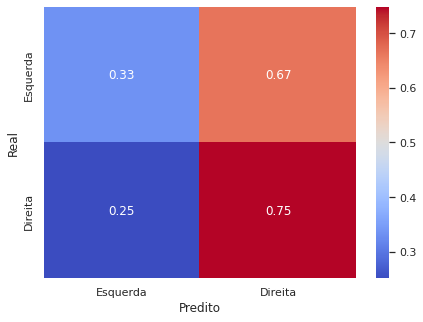

In [ ]:
classification_with_svm(X_3, y, 'scale', 0.01, 10)

###### Gunning fog

In [ ]:
X_4 = df_readability.drop(['flesch-kincaid', 'flesch-reading-ease', 'dale-chall', 'bias'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_4, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.521976
1    0.01       scale         0.540323
2     0.1        auto         0.524194
3     0.1       scale         0.537903
4       1        auto         0.519556
5       1       scale         0.535685
6      10        auto         0.523185
7      10       scale         0.533468
8     100        auto         0.524395
9     100       scale         0.530645


In [ ]:
# C = 0.01, gamma = scale

              precision    recall  f1-score   support

        left       0.57      0.33      0.42      2480
       right       0.53      0.75      0.62      2480

    accuracy                           0.54      4960
   macro avg       0.55      0.54      0.52      4960
weighted avg       0.55      0.54      0.52      4960



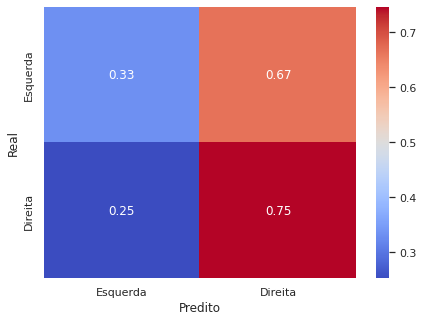

In [ ]:
classification_with_svm(X_4, y, 'scale', 0.01, 10)

##### 2 features

###### Flesch-Kincaid + Flesch reading ease

In [ ]:
X_12 = df_readability.drop(['dale-chall', 'gunning-fog', 'bias'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_12, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.512097
1    0.01       scale         0.543548
2     0.1        auto         0.512097
3     0.1       scale         0.538911
4       1        auto         0.520161
5       1       scale         0.536895
6      10        auto         0.513508
7      10       scale         0.536290
8     100        auto         0.513508
9     100       scale         0.535484


In [ ]:
# C = 0.01, gamma = scale

              precision    recall  f1-score   support

        left       0.58      0.31      0.40      2480
       right       0.53      0.78      0.63      2480

    accuracy                           0.54      4960
   macro avg       0.56      0.54      0.52      4960
weighted avg       0.56      0.54      0.52      4960



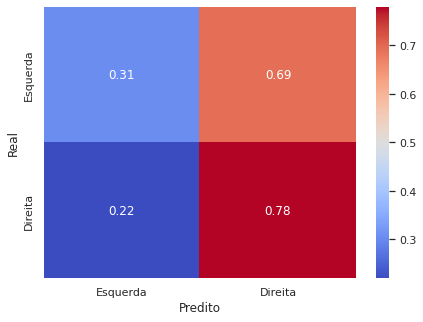

In [ ]:
classification_with_svm(X_12, y, 'scale', 0.01, 10)

###### Flesch-Kincaid + Dale-Chall

In [ ]:
X_13 = df_readability.drop(['flesch-reading-ease', 'gunning-fog', 'bias'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_13, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.516331
1    0.01       scale         0.542742
2     0.1        auto         0.526613
3     0.1       scale         0.540726
4       1        auto         0.513105
5       1       scale         0.536290
6      10        auto         0.509476
7      10       scale         0.535282
8     100        auto         0.497984
9     100       scale         0.532661


In [ ]:
# C = 0.01, gamma = scale

              precision    recall  f1-score   support

        left       0.58      0.32      0.41      2480
       right       0.53      0.77      0.63      2480

    accuracy                           0.54      4960
   macro avg       0.55      0.54      0.52      4960
weighted avg       0.55      0.54      0.52      4960



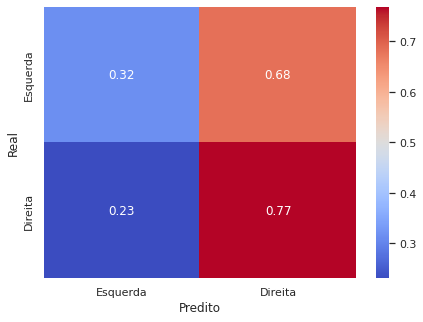

In [ ]:
classification_with_svm(X_13, y, 'scale', 0.01, 10)

###### Flesch-Kincaid + Gunning fog

In [ ]:
X_14 = df_readability.drop(['flesch-reading-ease', 'dale-chall', 'bias'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_14, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.507460
1    0.01       scale         0.540726
2     0.1        auto         0.507258
3     0.1       scale         0.538105
4       1        auto         0.505444
5       1       scale         0.536290
6      10        auto         0.513306
7      10       scale         0.533468
8     100        auto         0.509677
9     100       scale         0.529839


In [ ]:
# C = 0.01, gamma = scale

              precision    recall  f1-score   support

        left       0.57      0.33      0.42      2480
       right       0.53      0.75      0.62      2480

    accuracy                           0.54      4960
   macro avg       0.55      0.54      0.52      4960
weighted avg       0.55      0.54      0.52      4960



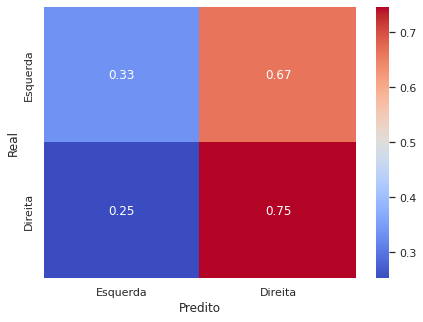

In [ ]:
classification_with_svm(X_14, y, 'scale', 0.01, 10)

###### Flesch reading ease + Dale-Chall

In [ ]:
X_23 = df_readability.drop(['flesch-kincaid', 'gunning-fog', 'bias'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_23, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.526815
1    0.01       scale         0.542339
2     0.1        auto         0.526815
3     0.1       scale         0.541935
4       1        auto         0.535685
5       1       scale         0.535685
6      10        auto         0.522379
7      10       scale         0.534879
8     100        auto         0.503427
9     100       scale         0.532661


In [ ]:
# C = 0.01, gamma = scale

              precision    recall  f1-score   support

        left       0.58      0.31      0.41      2480
       right       0.53      0.77      0.63      2480

    accuracy                           0.54      4960
   macro avg       0.55      0.54      0.52      4960
weighted avg       0.55      0.54      0.52      4960



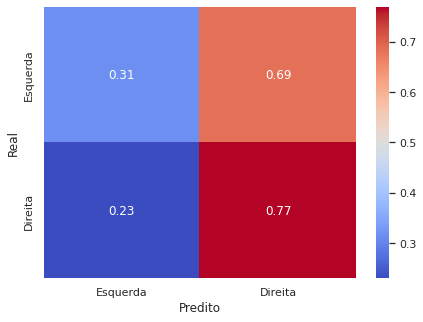

In [ ]:
classification_with_svm(X_23, y, 'scale', 0.01, 10)

###### Flesch reading ease + Gunning fog

In [ ]:
X_24 = df_readability.drop(['flesch-kincaid', 'dale-chall', 'bias'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_24, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.507863
1    0.01       scale         0.543548
2     0.1        auto         0.507863
3     0.1       scale         0.538710
4       1        auto         0.523589
5       1       scale         0.536895
6      10        auto         0.521976
7      10       scale         0.536290
8     100        auto         0.517944
9     100       scale         0.535484


In [ ]:
# C = 0.01, gamma = scale

              precision    recall  f1-score   support

        left       0.58      0.31      0.40      2480
       right       0.53      0.78      0.63      2480

    accuracy                           0.54      4960
   macro avg       0.56      0.54      0.52      4960
weighted avg       0.56      0.54      0.52      4960



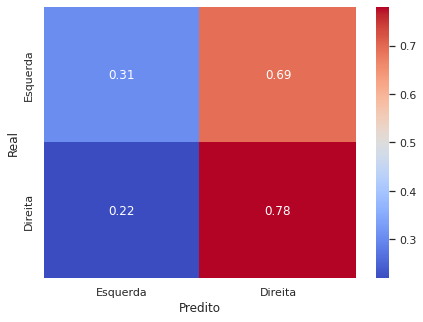

In [ ]:
classification_with_svm(X_24, y, 'scale', 0.01, 10)

###### Dale-Chall + Gunning fog

In [ ]:
X_34 = df_readability.drop(['flesch-kincaid', 'flesch-reading-ease', 'bias'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_34, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.525000
1    0.01       scale         0.543145
2     0.1        auto         0.524395
3     0.1       scale         0.540524
4       1        auto         0.529032
5       1       scale         0.536290
6      10        auto         0.527419
7      10       scale         0.535081
8     100        auto         0.528226
9     100       scale         0.533065


              precision    recall  f1-score   support

        left       0.58      0.32      0.41      2480
       right       0.53      0.77      0.63      2480

    accuracy                           0.54      4960
   macro avg       0.55      0.54      0.52      4960
weighted avg       0.55      0.54      0.52      4960



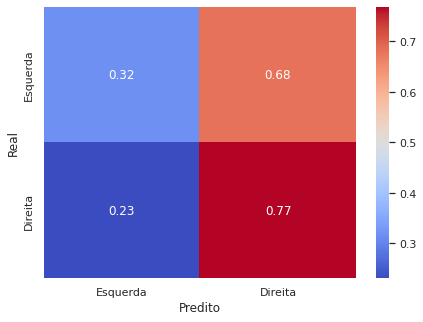

In [ ]:
classification_with_svm(X_34, y, 'scale', 0.01, 10)

##### 3 features

###### Flesch-Kincaid + Flesch reading ease + Dale-Chall
 

In [ ]:
X_123 = df_readability.drop(['gunning-fog', 'bias'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_123, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.516935
1    0.01       scale         0.544355
2     0.1        auto         0.516935
3     0.1       scale         0.538508
4       1        auto         0.525202
5       1       scale         0.536694
6      10        auto         0.516532
7      10       scale         0.537298
8     100        auto         0.507863
9     100       scale         0.534677


              precision    recall  f1-score   support

        left       0.58      0.31      0.40      2480
       right       0.53      0.78      0.63      2480

    accuracy                           0.54      4960
   macro avg       0.56      0.54      0.52      4960
weighted avg       0.56      0.54      0.52      4960



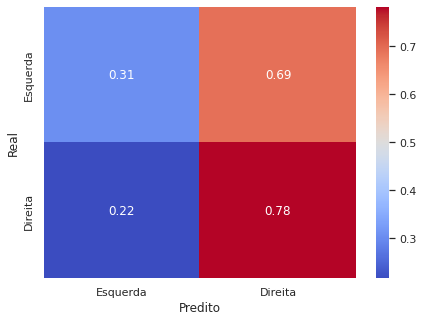

In [ ]:
classification_with_svm(X_123, y, 'scale', 0.01, 10)

###### Flesch-Kincaid + Flesch reading ease + Gunning fog

In [ ]:
X_124 = df_readability.drop(['dale-chall', 'bias'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_124, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.507258
1    0.01       scale         0.544153
2     0.1        auto         0.507258
3     0.1       scale         0.538105
4       1        auto         0.527419
5       1       scale         0.537097
6      10        auto         0.517944
7      10       scale         0.537097
8     100        auto         0.517944
9     100       scale         0.536089


In [ ]:
# C = 0.01, gamma = scale

              precision    recall  f1-score   support

        left       0.59      0.30      0.40      2480
       right       0.53      0.79      0.63      2480

    accuracy                           0.54      4960
   macro avg       0.56      0.54      0.52      4960
weighted avg       0.56      0.54      0.52      4960



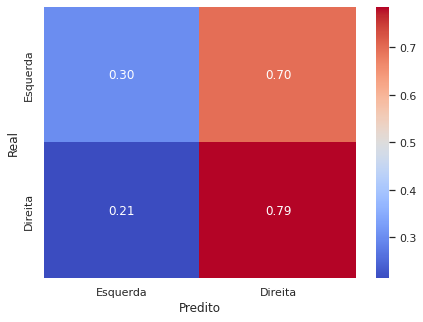

In [ ]:
classification_with_svm(X_124, y, 'scale', 0.01, 10)

###### Flesch-Kincaid  + Dale-Chall + Gunning fog

In [ ]:
X_134 = df_readability.drop(['flesch-reading-ease', 'bias'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_134, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.518548
1    0.01       scale         0.541734
2     0.1        auto         0.519355
3     0.1       scale         0.539919
4       1        auto         0.509879
5       1       scale         0.535685
6      10        auto         0.514516
7      10       scale         0.534677
8     100        auto         0.507863
9     100       scale         0.532460


In [ ]:
# C = 0.01, gamma = scale

              precision    recall  f1-score   support

        left       0.58      0.32      0.41      2480
       right       0.53      0.76      0.62      2480

    accuracy                           0.54      4960
   macro avg       0.55      0.54      0.52      4960
weighted avg       0.55      0.54      0.52      4960



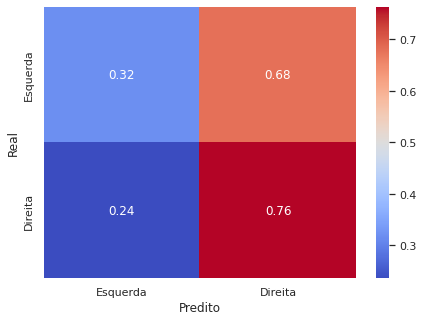

In [ ]:
classification_with_svm(X_134, y, 'scale', 0.01, 10)

###### Flesch reading ease + Dale-Chall + Gunning fog

In [ ]:
X_234 = df_readability.drop(['flesch-kincaid', 'bias'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_234, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.513306
1    0.01       scale         0.544758
2     0.1        auto         0.513306
3     0.1       scale         0.538306
4       1        auto         0.528831
5       1       scale         0.536694
6      10        auto         0.520968
7      10       scale         0.536895
8     100        auto         0.519355
9     100       scale         0.534476


In [ ]:
# C = 0.01, gamma = scale

              precision    recall  f1-score   support

        left       0.59      0.31      0.40      2480
       right       0.53      0.78      0.63      2480

    accuracy                           0.54      4960
   macro avg       0.56      0.54      0.52      4960
weighted avg       0.56      0.54      0.52      4960



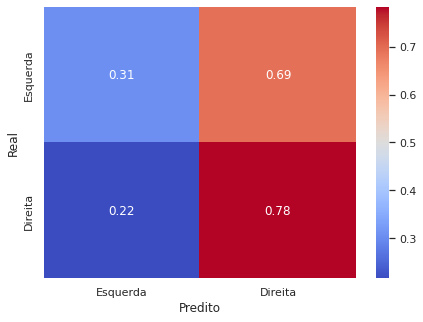

In [ ]:
classification_with_svm(X_234, y, 'scale', 0.01, 10)

##### 4 features

In [ ]:
X_1234 = df_readability.drop(['bias'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_1234, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.515121
1    0.01       scale         0.544355
2     0.1        auto         0.515121
3     0.1       scale         0.538306
4       1        auto         0.528427
5       1       scale         0.537097
6      10        auto         0.515323
7      10       scale         0.536895
8     100        auto         0.512097
9     100       scale         0.534879


In [ ]:
# C = 0.01, gamma = scale

              precision    recall  f1-score   support

        left       0.59      0.30      0.40      2480
       right       0.53      0.79      0.63      2480

    accuracy                           0.54      4960
   macro avg       0.56      0.54      0.52      4960
weighted avg       0.56      0.54      0.52      4960



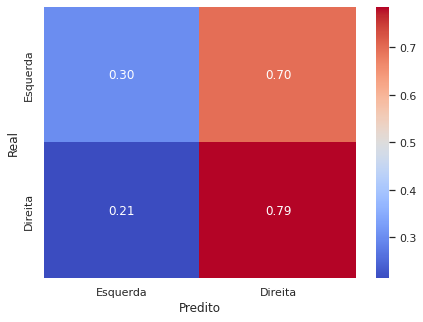

In [ ]:
classification_with_svm(X_1234, y, 'scale', 0.01, 10)

#### News February - Readability Features per News (Left, Right)

In [ ]:
df_readability_names = ["flesch-kincaid", "flesch-reading-ease", "dale-chall", "gunning-fog", "bias"]
df_readability = pd.DataFrame(columns = df_readability_names)
df_readability

,flesch-kincaid,flesch-reading-ease,dale-chall,gunning-fog,bias


In [ ]:
import textstat

for value in df_news_february.values:
  bias = ""
  if "left" in value[3]:
    bias = "left"
  else:
    bias = "right"
  content = preprocess(value[2])
  flesch_kincaid = textstat.flesch_kincaid_grade(content)
  flesch_reading = textstat.flesch_reading_ease(content)
  dale_chall = textstat.dale_chall_readability_score(content)
  gunning_fog = textstat.gunning_fog(content)
  df_readability = df_readability.append({"flesch-kincaid": flesch_kincaid, "flesch-reading-ease": flesch_reading, "dale-chall": dale_chall, "gunning-fog": gunning_fog, "bias": bias}, ignore_index=True)
df_readability

,flesch-kincaid,flesch-reading-ease,dale-chall,gunning-fog,bias
0,1512.2,-3855.57,197.98,1550.56,left
1,548.9,-1343.10,77.07,564.00,left
2,13.5,28.84,10.98,9.15,left
3,1270.0,-3219.84,167.81,1302.82,left
4,906.5,-2279.27,120.80,928.82,left
...,...,...,...,...,...
11515,235.3,-532.46,37.26,242.30,right
11516,130.0,-258.41,24.91,134.80,right
11517,168.3,-352.46,28.51,173.22,right
11518,175.7,-377.16,29.95,180.51,right


In [ ]:
y = df_readability['bias']

##### 1 feature

###### Flesch-Kincaid

In [ ]:
X_1 = df_readability.drop(['flesch-reading-ease', 'dale-chall', 'gunning-fog', 'bias'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_1, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.501736
1    0.01       scale         0.518663
2     0.1        auto         0.507899
3     0.1       scale         0.519010
4       1        auto         0.506771
5       1       scale         0.517795
6      10        auto         0.504340
7      10       scale         0.519010
8     100        auto         0.501128
9     100       scale         0.518663


In [ ]:
# C = 0.01, gamma = scale

              precision    recall  f1-score   support

        left       0.54      0.22      0.31      5740
       right       0.51      0.82      0.63      5780

    accuracy                           0.52     11520
   macro avg       0.53      0.52      0.47     11520
weighted avg       0.53      0.52      0.47     11520



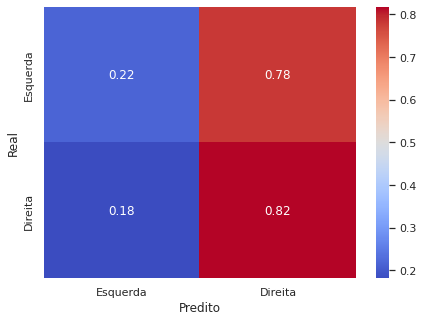

In [ ]:
classification_with_svm(X_1, y, 'scale', 0.1, 10)

###### Flesch reading ease

In [ ]:
X_2 = df_readability.drop(['flesch-kincaid', 'dale-chall', 'gunning-fog', 'bias'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_2, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.501736
1    0.01       scale         0.517708
2     0.1        auto         0.497135
3     0.1       scale         0.519271
4       1        auto         0.502257
5       1       scale         0.519184
6      10        auto         0.505382
7      10       scale         0.519271
8     100        auto         0.502865
9     100       scale         0.520312


In [ ]:
# C = 0.01, gamma = scale

              precision    recall  f1-score   support

        left       0.55      0.20      0.29      5740
       right       0.51      0.84      0.64      5780

    accuracy                           0.52     11520
   macro avg       0.53      0.52      0.47     11520
weighted avg       0.53      0.52      0.47     11520



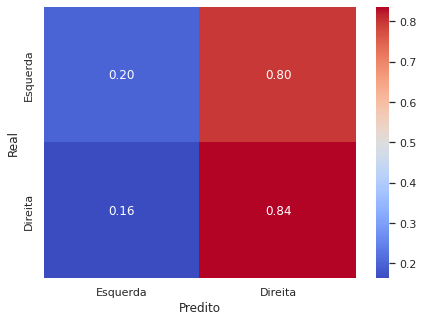

In [ ]:
classification_with_svm(X_2, y, 'scale', 100, 10)

###### Dale-Chall 

In [ ]:
X_3 = df_readability.drop(['flesch-kincaid', 'flesch-reading-ease', 'gunning-fog', 'bias'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_3, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.501736
1    0.01       scale         0.517882
2     0.1        auto         0.503472
3     0.1       scale         0.519878
4       1        auto         0.498177
5       1       scale         0.519358
6      10        auto         0.494097
7      10       scale         0.519184
8     100        auto         0.495573
9     100       scale         0.520139


In [ ]:
# C = 0.01, gamma = scale

              precision    recall  f1-score   support

        left       0.55      0.20      0.30      5740
       right       0.51      0.83      0.64      5780

    accuracy                           0.52     11520
   macro avg       0.53      0.52      0.47     11520
weighted avg       0.53      0.52      0.47     11520



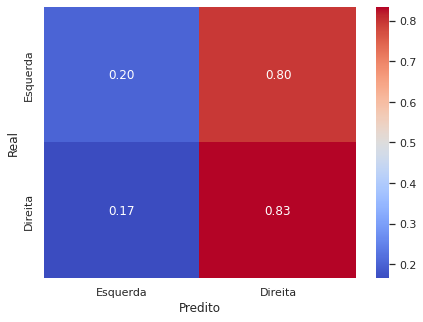

In [ ]:
classification_with_svm(X_3, y, 'scale', 100, 10)

###### Gunning fog

In [ ]:
X_4 = df_readability.drop(['flesch-kincaid', 'flesch-reading-ease', 'dale-chall', 'bias'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_4, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.501736
1    0.01       scale         0.518490
2     0.1        auto         0.506250
3     0.1       scale         0.518142
4       1        auto         0.511719
5       1       scale         0.518576
6      10        auto         0.519965
7      10       scale         0.519184
8     100        auto         0.524392
9     100       scale         0.518056


In [ ]:
# C = 0.01, gamma = scale

              precision    recall  f1-score   support

        left       0.52      0.48      0.50      5740
       right       0.52      0.56      0.54      5780

    accuracy                           0.52     11520
   macro avg       0.52      0.52      0.52     11520
weighted avg       0.52      0.52      0.52     11520



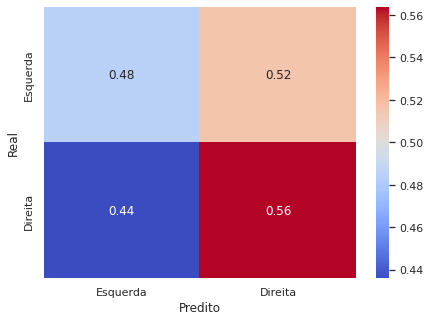

In [ ]:
classification_with_svm(X_4, y, 'auto', 100, 10)

##### 2 features

###### Flesch-Kincaid + Flesch reading ease

In [ ]:
X_12 = df_readability.drop(['dale-chall', 'gunning-fog', 'bias'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_12, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.501736
1    0.01       scale         0.518229
2     0.1        auto         0.496788
3     0.1       scale         0.519358
4       1        auto         0.512413
5       1       scale         0.518924
6      10        auto         0.510243
7      10       scale         0.516753
8     100        auto         0.510156
9     100       scale         0.514149


In [ ]:
# C = 0.01, gamma = scale

              precision    recall  f1-score   support

        left       0.55      0.20      0.29      5740
       right       0.51      0.84      0.64      5780

    accuracy                           0.52     11520
   macro avg       0.53      0.52      0.46     11520
weighted avg       0.53      0.52      0.46     11520



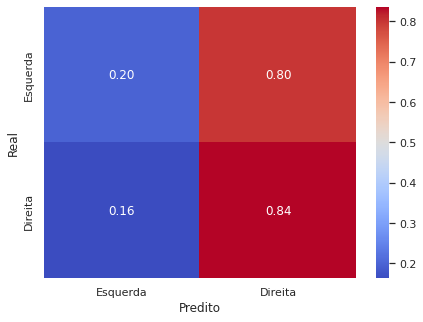

In [ ]:
classification_with_svm(X_12, y, 'scale', 0.1, 10)

###### Flesch-Kincaid + Dale-Chall

In [ ]:
X_13 = df_readability.drop(['flesch-reading-ease', 'gunning-fog', 'bias'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_13, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.501736
1    0.01       scale         0.518056
2     0.1        auto         0.507552
3     0.1       scale         0.518837
4       1        auto         0.496267
5       1       scale         0.517795
6      10        auto         0.502778
7      10       scale         0.518576
8     100        auto         0.497656
9     100       scale         0.518924


In [ ]:
# C = 0.01, gamma = scale

              precision    recall  f1-score   support

        left       0.55      0.20      0.29      5740
       right       0.51      0.84      0.64      5780

    accuracy                           0.52     11520
   macro avg       0.53      0.52      0.46     11520
weighted avg       0.53      0.52      0.46     11520



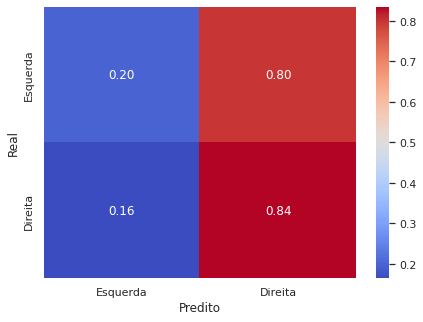

In [ ]:
classification_with_svm(X_13, y, 'scale', 100, 10)

###### Flesch-Kincaid + Gunning fog

In [ ]:
X_14 = df_readability.drop(['flesch-reading-ease', 'dale-chall', 'bias'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_14, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.501736
1    0.01       scale         0.518490
2     0.1        auto         0.505903
3     0.1       scale         0.518924
4       1        auto         0.514410
5       1       scale         0.518316
6      10        auto         0.512587
7      10       scale         0.518403
8     100        auto         0.515365
9     100       scale         0.518056


In [ ]:
# C = 0.01, gamma = scale

              precision    recall  f1-score   support

        left       0.54      0.22      0.31      5740
       right       0.51      0.81      0.63      5780

    accuracy                           0.52     11520
   macro avg       0.53      0.52      0.47     11520
weighted avg       0.53      0.52      0.47     11520



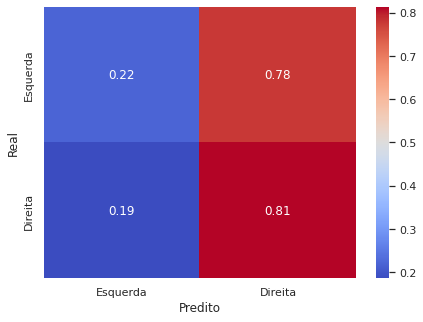

In [ ]:
classification_with_svm(X_14, y, 'scale', 0.1, 10)

###### Flesch reading ease + Dale-Chall

In [ ]:
X_23 = df_readability.drop(['flesch-kincaid', 'gunning-fog', 'bias'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_23, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.501736
1    0.01       scale         0.517795
2     0.1        auto         0.495399
3     0.1       scale         0.518837
4       1        auto         0.509462
5       1       scale         0.519358
6      10        auto         0.510243
7      10       scale         0.518229
8     100        auto         0.507639
9     100       scale         0.520399


In [ ]:
# C = 0.01, gamma = scale

              precision    recall  f1-score   support

        left       0.55      0.20      0.30      5740
       right       0.51      0.84      0.64      5780

    accuracy                           0.52     11520
   macro avg       0.53      0.52      0.47     11520
weighted avg       0.53      0.52      0.47     11520



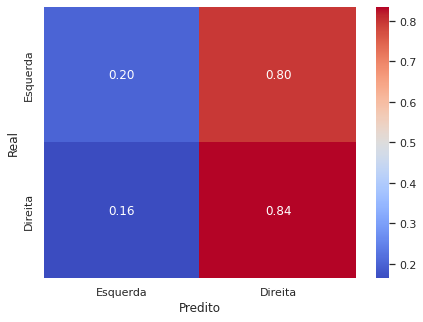

In [ ]:
classification_with_svm(X_23, y, 'scale', 100, 10)

###### Flesch reading ease + Gunning fog

In [ ]:
X_24 = df_readability.drop(['flesch-kincaid', 'dale-chall', 'bias'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_24, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.501736
1    0.01       scale         0.518142
2     0.1        auto         0.499566
3     0.1       scale         0.519010
4       1        auto         0.507552
5       1       scale         0.519358
6      10        auto         0.502344
7      10       scale         0.516580
8     100        auto         0.505642
9     100       scale         0.516059


In [ ]:
# C = 0.01, gamma = scale

              precision    recall  f1-score   support

        left       0.54      0.22      0.31      5740
       right       0.51      0.82      0.63      5780

    accuracy                           0.52     11520
   macro avg       0.53      0.52      0.47     11520
weighted avg       0.53      0.52      0.47     11520



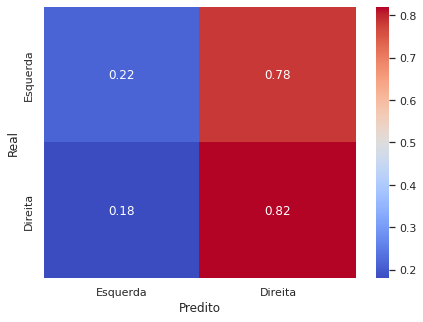

In [ ]:
classification_with_svm(X_24, y, 'scale', 1, 10)

###### Dale-Chall + Gunning fog

In [ ]:
X_34 = df_readability.drop(['flesch-kincaid', 'flesch-reading-ease', 'bias'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_34, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.501736
1    0.01       scale         0.517795
2     0.1        auto         0.507378
3     0.1       scale         0.518056
4       1        auto         0.511545
5       1       scale         0.517795
6      10        auto         0.511719
7      10       scale         0.516493
8     100        auto         0.514844
9     100       scale         0.516667


              precision    recall  f1-score   support

        left       0.54      0.22      0.32      5740
       right       0.51      0.81      0.63      5780

    accuracy                           0.52     11520
   macro avg       0.53      0.52      0.47     11520
weighted avg       0.53      0.52      0.47     11520



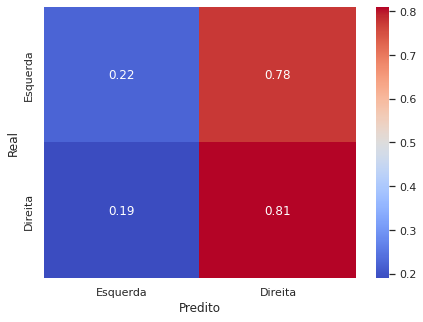

In [ ]:
classification_with_svm(X_34, y, 'scale', 0.1, 10)

##### 3 features

###### Flesch-Kincaid + Flesch reading ease + Dale-Chall
 

In [ ]:
X_123 = df_readability.drop(['gunning-fog', 'bias'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_123, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.501736
1    0.01       scale         0.518142
2     0.1        auto         0.496875
3     0.1       scale         0.519531
4       1        auto         0.516667
5       1       scale         0.519184
6      10        auto         0.509115
7      10       scale         0.516753
8     100        auto         0.504514
9     100       scale         0.514149


              precision    recall  f1-score   support

        left       0.55      0.20      0.29      5740
       right       0.51      0.84      0.64      5780

    accuracy                           0.52     11520
   macro avg       0.53      0.52      0.46     11520
weighted avg       0.53      0.52      0.46     11520



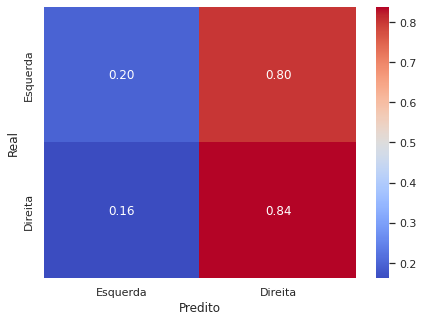

In [ ]:
classification_with_svm(X_123, y, 'scale', 0.1, 10)

###### Flesch-Kincaid + Flesch reading ease + Gunning fog

In [ ]:
X_124 = df_readability.drop(['dale-chall', 'bias'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_124, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.501736
1    0.01       scale         0.518229
2     0.1        auto         0.500955
3     0.1       scale         0.519271
4       1        auto         0.509635
5       1       scale         0.519010
6      10        auto         0.508333
7      10       scale         0.517014
8     100        auto         0.512066
9     100       scale         0.514757


In [ ]:
# C = 0.01, gamma = scale

              precision    recall  f1-score   support

        left       0.55      0.20      0.29      5740
       right       0.51      0.83      0.64      5780

    accuracy                           0.52     11520
   macro avg       0.53      0.52      0.46     11520
weighted avg       0.53      0.52      0.47     11520



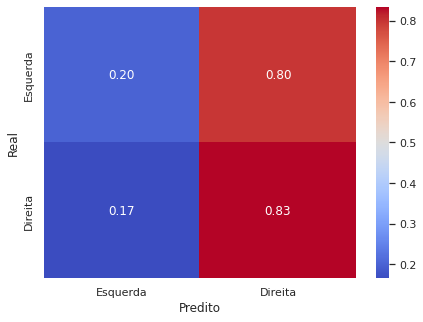

In [ ]:
classification_with_svm(X_124, y, 'scale', 0.1, 10)

###### Flesch-Kincaid  + Dale-Chall + Gunning fog

In [ ]:
X_134 = df_readability.drop(['flesch-reading-ease', 'bias'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_134, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.501736
1    0.01       scale         0.517882
2     0.1        auto         0.502865
3     0.1       scale         0.518576
4       1        auto         0.514583
5       1       scale         0.517795
6      10        auto         0.519358
7      10       scale         0.517101
8     100        auto         0.514410
9     100       scale         0.516840


In [ ]:
# C = 0.01, gamma = scale

              precision    recall  f1-score   support

        left       0.52      0.52      0.52      5740
       right       0.52      0.52      0.52      5780

    accuracy                           0.52     11520
   macro avg       0.52      0.52      0.52     11520
weighted avg       0.52      0.52      0.52     11520



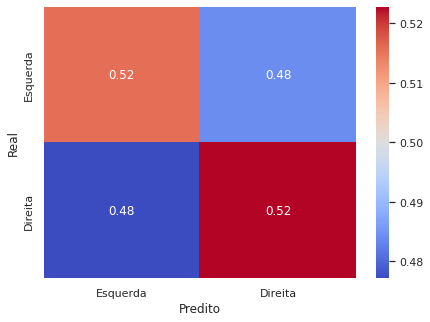

In [ ]:
classification_with_svm(X_134, y, 'auto', 10, 10)

###### Flesch reading ease + Dale-Chall + Gunning fog

In [ ]:
X_234 = df_readability.drop(['flesch-kincaid', 'bias'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_234, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.501736
1    0.01       scale         0.518229
2     0.1        auto         0.498611
3     0.1       scale         0.518837
4       1        auto         0.505208
5       1       scale         0.519444
6      10        auto         0.504427
7      10       scale         0.516406
8     100        auto         0.499306
9     100       scale         0.515451


In [ ]:
# C = 0.01, gamma = scale

              precision    recall  f1-score   support

        left       0.54      0.22      0.31      5740
       right       0.51      0.82      0.63      5780

    accuracy                           0.52     11520
   macro avg       0.53      0.52      0.47     11520
weighted avg       0.53      0.52      0.47     11520



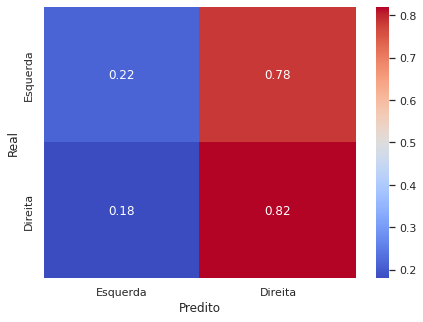

In [ ]:
classification_with_svm(X_234, y, 'scale', 1, 10)

##### 4 features

In [ ]:
X_1234 = df_readability.drop(['bias'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_1234, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.501736
1    0.01       scale         0.518229
2     0.1        auto         0.500781
3     0.1       scale         0.519531
4       1        auto         0.506597
5       1       scale         0.519184
6      10        auto         0.504774
7      10       scale         0.517014
8     100        auto         0.503472
9     100       scale         0.513976


In [ ]:
# C = 0.01, gamma = scale

              precision    recall  f1-score   support

        left       0.55      0.20      0.29      5740
       right       0.51      0.84      0.64      5780

    accuracy                           0.52     11520
   macro avg       0.53      0.52      0.47     11520
weighted avg       0.53      0.52      0.47     11520



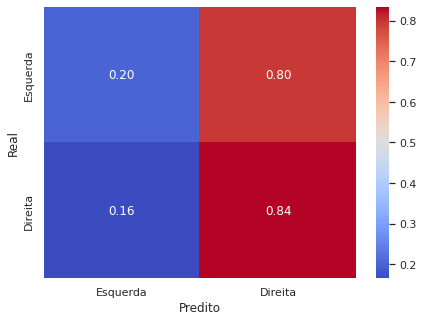

In [ ]:
classification_with_svm(X_1234, y, 'scale', 0.1, 10)

#### News July - Readability Features per Portal (Left, Right)

In [ ]:
df_portals_content_names = ["source", "content", "bias"]
df_portals_content = pd.DataFrame(columns = df_portals_content_names)
df_portals_content

,source,content,bias


In [ ]:
last_source = "berkeleyside"
df_portals_content = df_portals_content.append({'source': last_source, 'content': "", "bias": "left"}, ignore_index=True)

# add all news sources to dataframe 
for value in df_news_july.values:
  source = value[0]
  bias = ""
  if "left" in value[3]:
    bias = "left"
  else:
    bias = "right"
  if source != last_source:
    df_portals_content = df_portals_content.append({'source': source, 'content': "", "bias": bias}, ignore_index=True)
    last_source = source

df_portals_content

,source,content,bias
0,berkeleyside,,left
1,migrationpolicy,,left
2,deadline,,left
3,washingtonpress,,left
4,thehindubusinessline,,right
...,...,...,...
243,sun-sentinel,,right
244,tasnimnews,,right
245,nccivitas,,right
246,mexiconewsdaily,,left


In [ ]:
# add all news content to news sources 
for index, row in df_portals_content.iterrows():
  source = row['source']
  content = ""
  rows_1 = df_news_july[df_news_july['Source'] == source]
  for index_1, row_1 in rows_1.iterrows():
    content += preprocess(row_1['Content'])
  df_portals_content.at[index, 'content'] = content

df_portals_content

,source,content,bias
0,berkeleyside,when the homeowner did not voluntarily repair ...,left
1,migrationpolicy,mpis us immigration policy program analyzes us...,left
2,deadline,fifty years agoon may to be exactunited arti...,left
3,washingtonpress,k shares share this story a day after the unpr...,left
4,thehindubusinessline,a total of five girls of power generating comp...,right
...,...,...,...
243,sun-sentinel,renee steele rosomoff of hollywood florida for...,right
244,tasnimnews,at the moment we are forming bilateral meeting...,right
245,nccivitas,february by ray nothstine simple share butto...,right
246,mexiconewsdaily,a federal judge today ordered three former pem...,left


In [ ]:
df_readability_names = ["source", "content", "flesch-kincaid", "flesch-reading-ease", "dale-chall", "gunning-fog", "bias"]
df_readability = pd.DataFrame(columns = df_readability_names)
df_readability

,source,content,flesch-kincaid,flesch-reading-ease,dale-chall,gunning-fog,bias


In [ ]:
df_readability = pd.concat([df_portals_content, df_readability])
df_readability

,source,content,bias,flesch-kincaid,flesch-reading-ease,dale-chall,gunning-fog
0,berkeleyside,when the homeowner did not voluntarily repair ...,left,NaN,NaN,NaN,NaN
1,migrationpolicy,mpis us immigration policy program analyzes us...,left,NaN,NaN,NaN,NaN
2,deadline,fifty years agoon may to be exactunited arti...,left,NaN,NaN,NaN,NaN
3,washingtonpress,k shares share this story a day after the unpr...,left,NaN,NaN,NaN,NaN
4,thehindubusinessline,a total of five girls of power generating comp...,right,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
243,sun-sentinel,renee steele rosomoff of hollywood florida for...,right,NaN,NaN,NaN,NaN
244,tasnimnews,at the moment we are forming bilateral meeting...,right,NaN,NaN,NaN,NaN
245,nccivitas,february by ray nothstine simple share butto...,right,NaN,NaN,NaN,NaN
246,mexiconewsdaily,a federal judge today ordered three former pem...,left,NaN,NaN,NaN,NaN


In [ ]:
import textstat

for index, row in df_readability.iterrows():
  text = preprocess(row['content'])
  flesch_kincaid = textstat.flesch_kincaid_grade(text)
  flesch_reading = textstat.flesch_reading_ease(text)
  dale_chall = textstat.dale_chall_readability_score(text)
  gunning_fog = textstat.gunning_fog(text)
  df_readability.at[index, 'flesch-kincaid'] = flesch_kincaid
  df_readability.at[index, 'flesch-reading-ease'] = flesch_reading
  df_readability.at[index, 'dale-chall'] = dale_chall
  df_readability.at[index, 'gunning-fog'] = gunning_fog

df_readability

,source,content,bias,flesch-kincaid,flesch-reading-ease,dale-chall,gunning-fog
0,berkeleyside,when the homeowner did not voluntarily repair ...,left,6657.9,-17242.06,852.75,6828.57
1,migrationpolicy,mpis us immigration policy program analyzes us...,left,3053.5,-7877.68,394.14,3129.35
2,deadline,fifty years agoon may to be exactunited arti...,left,3723.1,-9604.19,480.3,3819.1
3,washingtonpress,k shares share this story a day after the unpr...,left,4737.9,-12250.63,608.86,4859.09
4,thehindubusinessline,a total of five girls of power generating comp...,right,5076.8,-13127.25,651.14,5206.37
...,...,...,...,...,...,...,...
243,sun-sentinel,renee steele rosomoff of hollywood florida for...,right,1314.1,-3334.53,174.49,1348.47
244,tasnimnews,at the moment we are forming bilateral meeting...,right,2801.2,-7210.14,362.71,2872.59
245,nccivitas,february by ray nothstine simple share butto...,right,6120.1,-15847.79,783.72,6275.87
246,mexiconewsdaily,a federal judge today ordered three former pem...,left,2546.1,-6546.33,330.35,2611.23


In [ ]:
y = df_readability['bias']

##### 1 feature

###### Flesch-Kincaid

In [ ]:
X_1 = df_readability.drop(['flesch-reading-ease', 'dale-chall', 'gunning-fog', 'bias', 'source', 'content'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_1, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.484000
1    0.01       scale         0.504833
2     0.1        auto         0.484000
3     0.1       scale         0.576833
4       1        auto         0.463833
5       1       scale         0.585000
6      10        auto         0.467833
7      10       scale         0.585000
8     100        auto         0.467833
9     100       scale         0.544000


In [ ]:
# C = 1, gamma = scale

              precision    recall  f1-score   support

        left       0.71      0.29      0.41       124
       right       0.55      0.88      0.68       124

    accuracy                           0.58       248
   macro avg       0.63      0.58      0.55       248
weighted avg       0.63      0.58      0.55       248



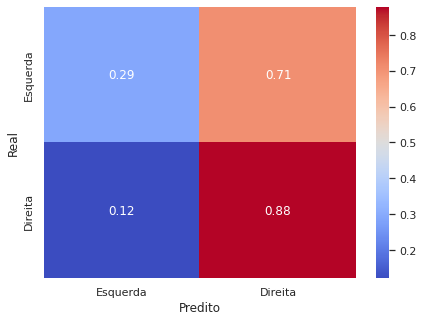

In [ ]:
classification_with_svm(X_1, y, 'scale', 1, 10)

###### Flesch reading ease

In [ ]:
X_2 = df_readability.drop(['flesch-kincaid', 'dale-chall', 'gunning-fog', 'bias', 'source', 'content'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_2, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.492333
1    0.01       scale         0.504833
2     0.1        auto         0.492333
3     0.1       scale         0.576833
4       1        auto         0.496333
5       1       scale         0.585000
6      10        auto         0.492167
7      10       scale         0.585000
8     100        auto         0.492167
9     100       scale         0.544000


In [ ]:
# C = 0.01, gamma = scale

              precision    recall  f1-score   support

        left       0.71      0.29      0.41       124
       right       0.55      0.88      0.68       124

    accuracy                           0.58       248
   macro avg       0.63      0.58      0.55       248
weighted avg       0.63      0.58      0.55       248



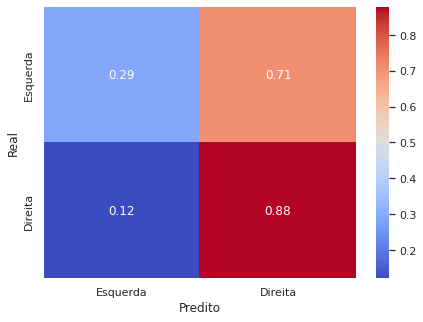

In [ ]:
classification_with_svm(X_2, y, 'scale', 1, 10)

###### Dale-Chall 

In [ ]:
X_3 = df_readability.drop(['flesch-kincaid', 'flesch-reading-ease', 'gunning-fog', 'bias', 'source', 'content'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_3, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.509000
1    0.01       scale         0.504833
2     0.1        auto         0.509000
3     0.1       scale         0.576833
4       1        auto         0.533167
5       1       scale         0.585000
6      10        auto         0.508667
7      10       scale         0.581000
8     100        auto         0.512000
9     100       scale         0.544000


In [ ]:
# C = 0.01, gamma = scale

              precision    recall  f1-score   support

        left       0.71      0.29      0.41       124
       right       0.55      0.88      0.68       124

    accuracy                           0.58       248
   macro avg       0.63      0.58      0.55       248
weighted avg       0.63      0.58      0.55       248



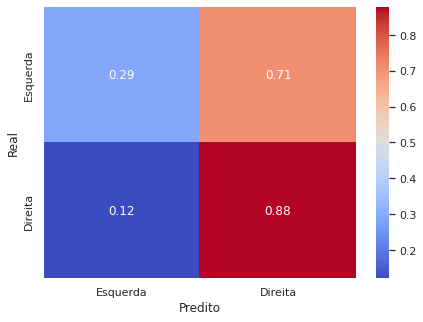

In [ ]:
classification_with_svm(X_3, y, 'scale', 1, 10)

###### Gunning fog

In [ ]:
X_4 = df_readability.drop(['flesch-kincaid', 'flesch-reading-ease', 'dale-chall', 'bias', 'source', 'content'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_4, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.479833
1    0.01       scale         0.504833
2     0.1        auto         0.479833
3     0.1       scale         0.576833
4       1        auto         0.483667
5       1       scale         0.585000
6      10        auto         0.479667
7      10       scale         0.585000
8     100        auto         0.479667
9     100       scale         0.544000


In [ ]:
# C = 0.01, gamma = scale

              precision    recall  f1-score   support

        left       0.71      0.29      0.41       124
       right       0.55      0.88      0.68       124

    accuracy                           0.58       248
   macro avg       0.63      0.58      0.55       248
weighted avg       0.63      0.58      0.55       248



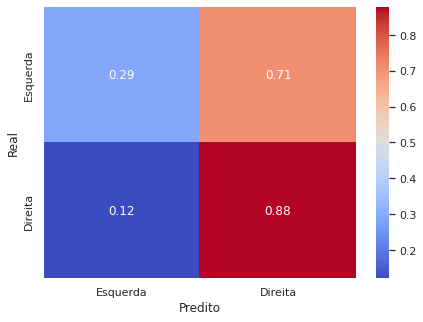

In [ ]:
classification_with_svm(X_4, y, 'scale', 1, 10)

##### 2 features

###### Flesch-Kincaid + Flesch reading ease

In [ ]:
X_12 = df_readability.drop(['dale-chall', 'gunning-fog', 'bias', 'source', 'content'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_12, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.492333
1    0.01       scale         0.509000
2     0.1        auto         0.492333
3     0.1       scale         0.581000
4       1        auto         0.496333
5       1       scale         0.584833
6      10        auto         0.496333
7      10       scale         0.580667
8     100        auto         0.496333
9     100       scale         0.584833


In [ ]:
# C = 1, gamma = scale

              precision    recall  f1-score   support

        left       0.71      0.28      0.40       124
       right       0.55      0.89      0.68       124

    accuracy                           0.58       248
   macro avg       0.63      0.58      0.54       248
weighted avg       0.63      0.58      0.54       248



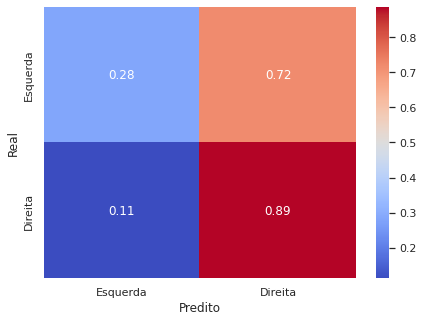

In [ ]:
classification_with_svm(X_12, y, 'scale', 1, 10)

###### Flesch-Kincaid + Dale-Chall

In [ ]:
X_13 = df_readability.drop(['flesch-reading-ease', 'gunning-fog', 'bias', 'source', 'content'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_13, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.479833
1    0.01       scale         0.513167
2     0.1        auto         0.479833
3     0.1       scale         0.589167
4       1        auto         0.475833
5       1       scale         0.588833
6      10        auto         0.471667
7      10       scale         0.584833
8     100        auto         0.471667
9     100       scale         0.589000


In [ ]:
# C = 0.1, gamma = scale

              precision    recall  f1-score   support

        left       0.71      0.30      0.42       124
       right       0.56      0.88      0.68       124

    accuracy                           0.59       248
   macro avg       0.63      0.59      0.55       248
weighted avg       0.63      0.59      0.55       248



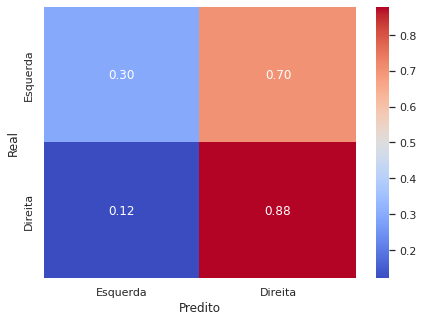

In [ ]:
classification_with_svm(X_13, y, 'scale', 0.1, 10)

###### Flesch-Kincaid + Gunning fog

In [ ]:
X_14 = df_readability.drop(['flesch-reading-ease', 'dale-chall', 'bias', 'source', 'content'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_14, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.479833
1    0.01       scale         0.504833
2     0.1        auto         0.479833
3     0.1       scale         0.576833
4       1        auto         0.483833
5       1       scale         0.585000
6      10        auto         0.483833
7      10       scale         0.585000
8     100        auto         0.483833
9     100       scale         0.544000


In [ ]:
# C = 1, gamma = scale

              precision    recall  f1-score   support

        left       0.71      0.29      0.41       124
       right       0.55      0.88      0.68       124

    accuracy                           0.58       248
   macro avg       0.63      0.58      0.55       248
weighted avg       0.63      0.58      0.55       248



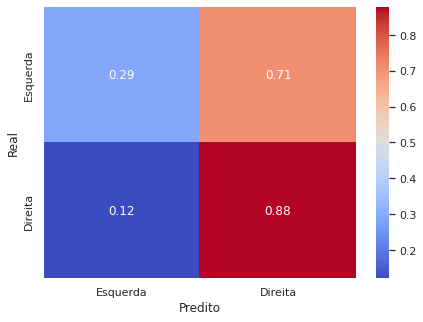

In [ ]:
classification_with_svm(X_14, y, 'scale', 1, 10)

###### Flesch reading ease + Dale-Chall

In [ ]:
X_23 = df_readability.drop(['flesch-kincaid', 'gunning-fog', 'bias', 'source', 'content'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_23, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.492333
1    0.01       scale         0.513167
2     0.1        auto         0.492333
3     0.1       scale         0.581000
4       1        auto         0.492167
5       1       scale         0.584833
6      10        auto         0.496167
7      10       scale         0.580667
8     100        auto         0.496167
9     100       scale         0.584833


In [ ]:
# C = 1, gamma = scale

              precision    recall  f1-score   support

        left       0.71      0.28      0.40       124
       right       0.55      0.89      0.68       124

    accuracy                           0.58       248
   macro avg       0.63      0.58      0.54       248
weighted avg       0.63      0.58      0.54       248



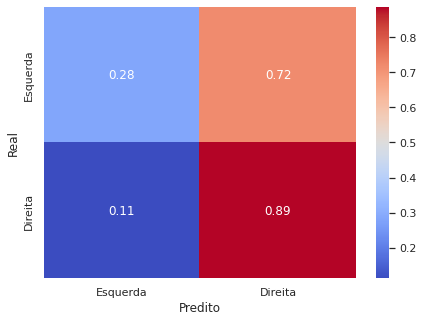

In [ ]:
classification_with_svm(X_23, y, 'scale', 1, 10)

###### Flesch reading ease + Gunning fog

In [ ]:
X_24 = df_readability.drop(['flesch-kincaid', 'dale-chall', 'bias', 'source', 'content'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_24, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.492333
1    0.01       scale         0.509000
2     0.1        auto         0.492333
3     0.1       scale         0.581000
4       1        auto         0.492333
5       1       scale         0.584833
6      10        auto         0.500333
7      10       scale         0.580667
8     100        auto         0.500333
9     100       scale         0.580833


In [ ]:
# C = 1, gamma = scale

              precision    recall  f1-score   support

        left       0.71      0.28      0.40       124
       right       0.55      0.89      0.68       124

    accuracy                           0.58       248
   macro avg       0.63      0.58      0.54       248
weighted avg       0.63      0.58      0.54       248



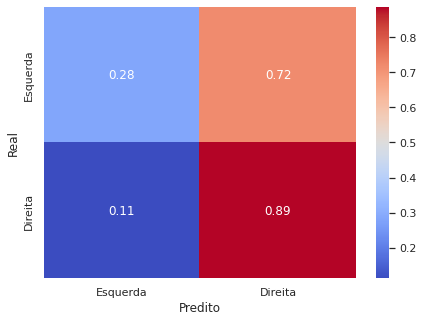

In [ ]:
classification_with_svm(X_24, y, 'scale', 1, 10)

###### Dale-Chall + Gunning fog

In [ ]:
X_34 = df_readability.drop(['flesch-kincaid', 'flesch-reading-ease', 'bias', 'source', 'content'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_34, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.479833
1    0.01       scale         0.513167
2     0.1        auto         0.479833
3     0.1       scale         0.589167
4       1        auto         0.483833
5       1       scale         0.588833
6      10        auto         0.471667
7      10       scale         0.584833
8     100        auto         0.471667
9     100       scale         0.589000


In [ ]:
# C = 1, gamma = scale

              precision    recall  f1-score   support

        left       0.71      0.30      0.42       124
       right       0.56      0.88      0.68       124

    accuracy                           0.59       248
   macro avg       0.63      0.59      0.55       248
weighted avg       0.63      0.59      0.55       248



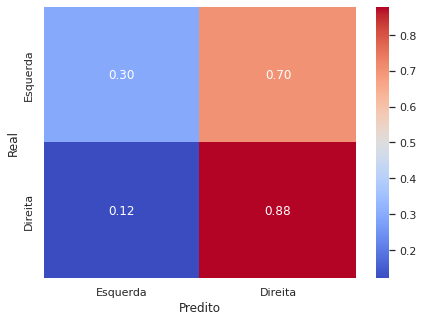

In [ ]:
classification_with_svm(X_34, y, 'scale', 0.1, 10)

##### 3 features

###### Flesch-Kincaid + Flesch reading ease + Dale-Chall
 

In [ ]:
X_123 = df_readability.drop(['gunning-fog', 'bias', 'source', 'content'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_123, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.492333
1    0.01       scale         0.509000
2     0.1        auto         0.492333
3     0.1       scale         0.585000
4       1        auto         0.500333
5       1       scale         0.589000
6      10        auto         0.500333
7      10       scale         0.580667
8     100        auto         0.500333
9     100       scale         0.580833


In [ ]:
# C = 1, gamma = scale

              precision    recall  f1-score   support

        left       0.72      0.29      0.41       124
       right       0.56      0.89      0.68       124

    accuracy                           0.59       248
   macro avg       0.64      0.59      0.55       248
weighted avg       0.64      0.59      0.55       248



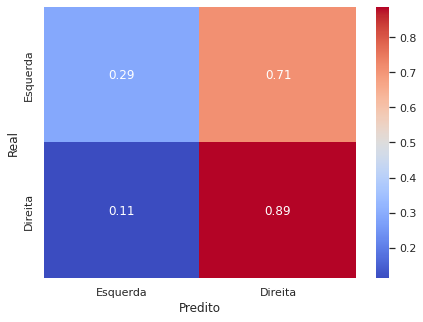

In [ ]:
classification_with_svm(X_123, y, 'scale', 1, 10)

###### Flesch-Kincaid + Flesch reading ease + Gunning fog

In [ ]:
X_124 = df_readability.drop(['dale-chall', 'bias', 'source', 'content'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_124, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.488167
1    0.01       scale         0.509000
2     0.1        auto         0.488167
3     0.1       scale         0.585000
4       1        auto         0.496333
5       1       scale         0.585000
6      10        auto         0.496333
7      10       scale         0.580667
8     100        auto         0.496333
9     100       scale         0.584833


In [ ]:
# C = 0.1, gamma = scale

              precision    recall  f1-score   support

        left       0.70      0.30      0.42       124
       right       0.55      0.87      0.68       124

    accuracy                           0.58       248
   macro avg       0.63      0.58      0.55       248
weighted avg       0.63      0.58      0.55       248



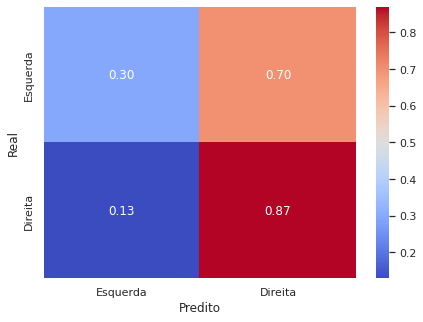

In [ ]:
classification_with_svm(X_124, y, 'scale', 0.1, 10)

###### Flesch-Kincaid  + Dale-Chall + Gunning fog

In [ ]:
X_134 = df_readability.drop(['flesch-reading-ease', 'bias', 'source', 'content'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_134, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.479833
1    0.01       scale         0.513167
2     0.1        auto         0.479833
3     0.1       scale         0.589167
4       1        auto         0.475667
5       1       scale         0.588833
6      10        auto         0.471667
7      10       scale         0.593000
8     100        auto         0.471667
9     100       scale         0.576833


In [ ]:
# C = 0.1, gamma = scale

              precision    recall  f1-score   support

        left       0.71      0.30      0.42       124
       right       0.56      0.88      0.68       124

    accuracy                           0.59       248
   macro avg       0.63      0.59      0.55       248
weighted avg       0.63      0.59      0.55       248



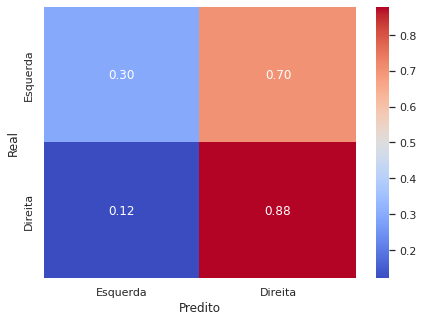

In [ ]:
classification_with_svm(X_134, y, 'scale', 0.1, 10)

###### Flesch reading ease + Dale-Chall + Gunning fog

In [ ]:
X_234 = df_readability.drop(['flesch-kincaid', 'bias', 'source', 'content'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_234, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.492333
1    0.01       scale         0.509000
2     0.1        auto         0.492333
3     0.1       scale         0.585000
4       1        auto         0.500333
5       1       scale         0.589000
6      10        auto         0.500333
7      10       scale         0.580667
8     100        auto         0.500333
9     100       scale         0.580833


In [ ]:
# C = 1, gamma = scale

              precision    recall  f1-score   support

        left       0.72      0.29      0.41       124
       right       0.56      0.89      0.68       124

    accuracy                           0.59       248
   macro avg       0.64      0.59      0.55       248
weighted avg       0.64      0.59      0.55       248



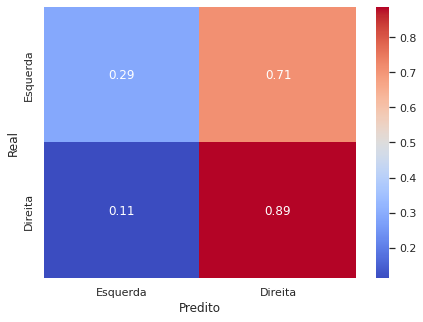

In [ ]:
classification_with_svm(X_234, y, 'scale', 1, 10)

##### 4 features

In [ ]:
X_1234 = df_readability.drop(['bias', 'source', 'content'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_1234, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.488167
1    0.01       scale         0.509000
2     0.1        auto         0.488167
3     0.1       scale         0.585000
4       1        auto         0.500333
5       1       scale         0.585000
6      10        auto         0.500333
7      10       scale         0.580667
8     100        auto         0.500333
9     100       scale         0.584833


In [ ]:
# C = 1, gamma = scale

              precision    recall  f1-score   support

        left       0.71      0.29      0.41       124
       right       0.55      0.88      0.68       124

    accuracy                           0.58       248
   macro avg       0.63      0.58      0.55       248
weighted avg       0.63      0.58      0.55       248



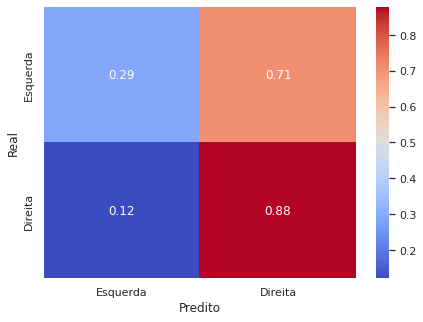

In [ ]:
classification_with_svm(X_1234, y, 'scale', 1, 10)

#### News February - Readability Features per Portal (Left, Right)

In [ ]:
df_portals_content_names = ["source", "content", "bias"]
df_portals_content = pd.DataFrame(columns = df_portals_content_names)
df_portals_content

,source,content,bias


In [ ]:
last_source = "berkeleyside"
df_portals_content = df_portals_content.append({'source': last_source, 'content': "", "bias": "left"}, ignore_index=True)

# add all news sources to dataframe 
for value in df_news_february.values:
  source = value[0]
  bias = ""
  if "left" in value[3]:
    bias = "left"
  else:
    bias = "right"
  if source != last_source:
    df_portals_content = df_portals_content.append({'source': source, 'content': "", "bias": bias}, ignore_index=True)
    last_source = source

df_portals_content

,source,content,bias
0,berkeleyside,,left
1,motherjones.com,,left
2,politisite.com,,right
3,townhall.com,,right
4,historynewsnetwork.org,,left
...,...,...,...
572,thefederalist.com,,right
573,ir.net,,left
574,commdiginews.com,,right
575,crosscut.com,,left


In [ ]:
# add all news content to news sources 
for index, row in df_portals_content.iterrows():
  source = row['source']
  content = ""
  rows_1 = df_news_february[df_news_february['Source'] == source]
  for index_1, row_1 in rows_1.iterrows():
    content += preprocess(row_1['Content'])
  df_portals_content.at[index, 'content'] = content

df_portals_content

,source,content,bias
0,berkeleyside,,left
1,motherjones.com,welcome to the mother jones website please rea...,left
2,politisite.com,west lafayette ind a video on social media sho...,right
3,townhall.com,top dem is not satisfied with white houses new...,right
4,historynewsnetwork.org,james robenaltis a presidential historian auth...,left
...,...,...,...
572,thefederalist.com,following the model of the us house democrats ...,right
573,ir.net,share boy do times change and so do the storie...,left
574,commdiginews.com,washington one of the biggest successes of th...,right
575,crosscut.com,i couldnt do everything to become an ethical c...,left


In [ ]:
df_readability_names = ["source", "content", "flesch-kincaid", "flesch-reading-ease", "dale-chall", "gunning-fog", "bias"]
df_readability = pd.DataFrame(columns = df_readability_names)
df_readability

,source,content,flesch-kincaid,flesch-reading-ease,dale-chall,gunning-fog,bias


In [ ]:
df_readability = pd.concat([df_portals_content, df_readability])
df_readability

,source,content,bias,flesch-kincaid,flesch-reading-ease,dale-chall,gunning-fog
0,berkeleyside,,left,NaN,NaN,NaN,NaN
1,motherjones.com,welcome to the mother jones website please rea...,left,NaN,NaN,NaN,NaN
2,politisite.com,west lafayette ind a video on social media sho...,right,NaN,NaN,NaN,NaN
3,townhall.com,top dem is not satisfied with white houses new...,right,NaN,NaN,NaN,NaN
4,historynewsnetwork.org,james robenaltis a presidential historian auth...,left,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
572,thefederalist.com,following the model of the us house democrats ...,right,NaN,NaN,NaN,NaN
573,ir.net,share boy do times change and so do the storie...,left,NaN,NaN,NaN,NaN
574,commdiginews.com,washington one of the biggest successes of th...,right,NaN,NaN,NaN,NaN
575,crosscut.com,i couldnt do everything to become an ethical c...,left,NaN,NaN,NaN,NaN


In [ ]:
import textstat

for index, row in df_readability.iterrows():
  text = preprocess(row['content'])
  flesch_kincaid = textstat.flesch_kincaid_grade(text)
  flesch_reading = textstat.flesch_reading_ease(text)
  dale_chall = textstat.dale_chall_readability_score(text)
  gunning_fog = textstat.gunning_fog(text)
  df_readability.at[index, 'flesch-kincaid'] = flesch_kincaid
  df_readability.at[index, 'flesch-reading-ease'] = flesch_reading
  df_readability.at[index, 'dale-chall'] = dale_chall
  df_readability.at[index, 'gunning-fog'] = gunning_fog

df_readability

,source,content,bias,flesch-kincaid,flesch-reading-ease,dale-chall,gunning-fog
0,berkeleyside,,left,-15.7,206.84,0.0,0.0
1,motherjones.com,welcome to the mother jones website please rea...,left,8062.6,-20903.51,1031.03,8268.29
2,politisite.com,west lafayette ind a video on social media sho...,right,4298.7,-11102.33,552.31,4408.89
3,townhall.com,top dem is not satisfied with white houses new...,right,5146.2,-13307.92,660.62,5278.55
4,historynewsnetwork.org,james robenaltis a presidential historian auth...,left,8426.1,-21849.49,1077.77,8641.98
...,...,...,...,...,...,...,...
572,thefederalist.com,following the model of the us house democrats ...,right,3745.3,-9667.46,482.8,3841.31
573,ir.net,share boy do times change and so do the storie...,left,6308.0,-16331.61,807.86,6469.67
574,commdiginews.com,washington one of the biggest successes of th...,right,7412.1,-19205.07,948.91,7602.55
575,crosscut.com,i couldnt do everything to become an ethical c...,left,3082.7,-7937.56,398.58,3162.31


In [ ]:
y = df_readability['bias']

##### 1 feature

###### Flesch-Kincaid

In [ ]:
X_1 = df_readability.drop(['flesch-reading-ease', 'dale-chall', 'gunning-fog', 'bias', 'source', 'content'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_1, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.497368
1    0.01       scale         0.514912
2     0.1        auto         0.497368
3     0.1       scale         0.539262
4       1        auto         0.457381
5       1       scale         0.544465
6      10        auto         0.462553
7      10       scale         0.532365
8     100        auto         0.464277
9     100       scale         0.520266


In [ ]:
# C = 1, gamma = scale

              precision    recall  f1-score   support

        left       0.61      0.25      0.35       288
       right       0.53      0.84      0.65       289

    accuracy                           0.54       577
   macro avg       0.57      0.54      0.50       577
weighted avg       0.57      0.54      0.50       577



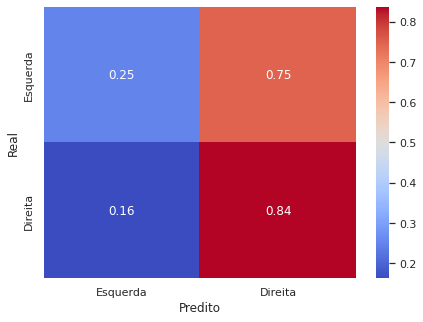

In [ ]:
classification_with_svm(X_1, y, 'scale', 1, 10)

###### Flesch reading ease

In [ ]:
X_2 = df_readability.drop(['flesch-kincaid', 'dale-chall', 'gunning-fog', 'bias', 'source', 'content'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_2, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.500877
1    0.01       scale         0.514912
2     0.1        auto         0.500877
3     0.1       scale         0.539262
4       1        auto         0.502541
5       1       scale         0.544465
6      10        auto         0.505989
7      10       scale         0.534090
8     100        auto         0.505989
9     100       scale         0.521990


In [ ]:
# C = 0.01, gamma = scale

              precision    recall  f1-score   support

        left       0.61      0.25      0.35       288
       right       0.53      0.84      0.65       289

    accuracy                           0.54       577
   macro avg       0.57      0.54      0.50       577
weighted avg       0.57      0.54      0.50       577



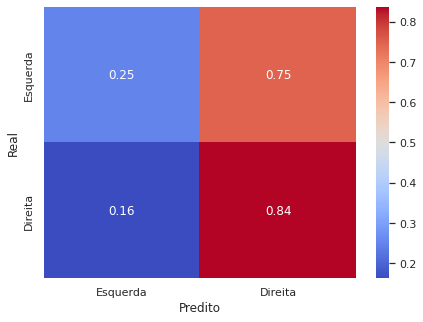

In [ ]:
classification_with_svm(X_2, y, 'scale', 1, 10)

###### Dale-Chall 

In [ ]:
X_3 = df_readability.drop(['flesch-kincaid', 'flesch-reading-ease', 'gunning-fog', 'bias', 'source', 'content'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_3, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.488596
1    0.01       scale         0.514912
2     0.1        auto         0.488596
3     0.1       scale         0.539262
4       1        auto         0.492287
5       1       scale         0.544465
6      10        auto         0.499153
7      10       scale         0.537538
8     100        auto         0.479946
9     100       scale         0.520266


In [ ]:
# C = 1, gamma = scale

              precision    recall  f1-score   support

        left       0.61      0.25      0.35       288
       right       0.53      0.84      0.65       289

    accuracy                           0.54       577
   macro avg       0.57      0.54      0.50       577
weighted avg       0.57      0.54      0.50       577



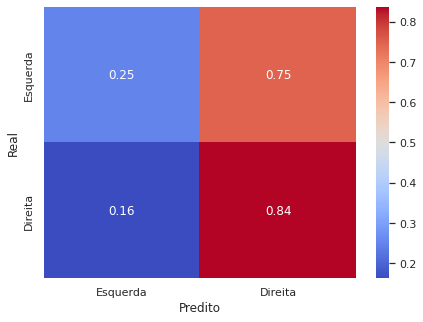

In [ ]:
classification_with_svm(X_3, y, 'scale', 1, 10)

###### Gunning fog

In [ ]:
X_4 = df_readability.drop(['flesch-kincaid', 'flesch-reading-ease', 'dale-chall', 'bias', 'source', 'content'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_4, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.502632
1    0.01       scale         0.514912
2     0.1        auto         0.502632
3     0.1       scale         0.539262
4       1        auto         0.466122
5       1       scale         0.544465
6      10        auto         0.467846
7      10       scale         0.532365
8     100        auto         0.480127
9     100       scale         0.520266


In [ ]:
# C = 1, gamma = scale

              precision    recall  f1-score   support

        left       0.61      0.25      0.35       288
       right       0.53      0.84      0.65       289

    accuracy                           0.54       577
   macro avg       0.57      0.54      0.50       577
weighted avg       0.57      0.54      0.50       577



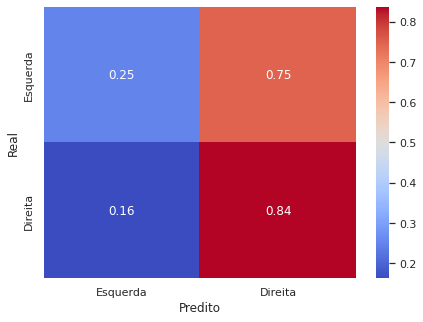

In [ ]:
classification_with_svm(X_4, y, 'scale', 1, 10)

##### 2 features

###### Flesch-Kincaid + Flesch reading ease

In [ ]:
X_12 = df_readability.drop(['dale-chall', 'gunning-fog', 'bias', 'source', 'content'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_12, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.497368
1    0.01       scale         0.514912
2     0.1        auto         0.497368
3     0.1       scale         0.544434
4       1        auto         0.502571
5       1       scale         0.546189
6      10        auto         0.500817
7      10       scale         0.546189
8     100        auto         0.500817
9     100       scale         0.535783


In [ ]:
# C = 1, gamma = scale

              precision    recall  f1-score   support

        left       0.60      0.26      0.37       288
       right       0.53      0.83      0.65       289

    accuracy                           0.55       577
   macro avg       0.57      0.55      0.51       577
weighted avg       0.57      0.55      0.51       577



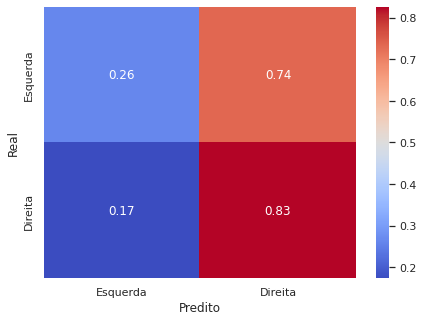

In [ ]:
classification_with_svm(X_12, y, 'scale', 1, 10)

###### Flesch-Kincaid + Dale-Chall

In [ ]:
X_13 = df_readability.drop(['flesch-reading-ease', 'gunning-fog', 'bias', 'source', 'content'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_13, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.495614
1    0.01       scale         0.514912
2     0.1        auto         0.495614
3     0.1       scale         0.542710
4       1        auto         0.457471
5       1       scale         0.551361
6      10        auto         0.478131
7      10       scale         0.547913
8     100        auto         0.476407
9     100       scale         0.528887


In [ ]:
# C = 1, gamma = scale

              precision    recall  f1-score   support

        left       0.62      0.26      0.37       288
       right       0.53      0.84      0.65       289

    accuracy                           0.55       577
   macro avg       0.58      0.55      0.51       577
weighted avg       0.58      0.55      0.51       577



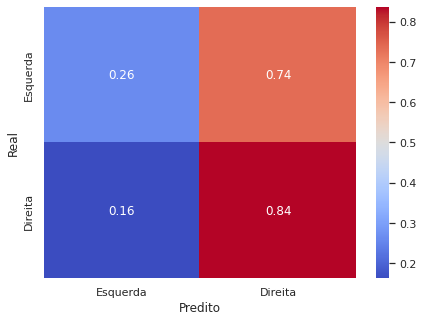

In [ ]:
classification_with_svm(X_13, y, 'scale', 1, 10)

###### Flesch-Kincaid + Gunning fog

In [ ]:
X_14 = df_readability.drop(['flesch-reading-ease', 'dale-chall', 'bias', 'source', 'content'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_14, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.499123
1    0.01       scale         0.514912
2     0.1        auto         0.499123
3     0.1       scale         0.539262
4       1        auto         0.492136
5       1       scale         0.544465
6      10        auto         0.490411
7      10       scale         0.532365
8     100        auto         0.492136
9     100       scale         0.520266


In [ ]:
# C = 1, gamma = scale

              precision    recall  f1-score   support

        left       0.61      0.25      0.35       288
       right       0.53      0.84      0.65       289

    accuracy                           0.54       577
   macro avg       0.57      0.54      0.50       577
weighted avg       0.57      0.54      0.50       577



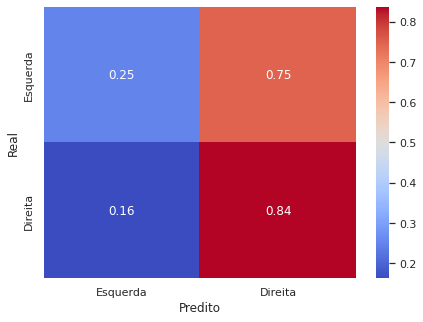

In [ ]:
classification_with_svm(X_14, y, 'scale', 1, 10)

###### Flesch reading ease + Dale-Chall

In [ ]:
X_23 = df_readability.drop(['flesch-kincaid', 'gunning-fog', 'bias', 'source', 'content'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_23, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.497368
1    0.01       scale         0.514912
2     0.1        auto         0.497368
3     0.1       scale         0.542710
4       1        auto         0.495554
5       1       scale         0.549637
6      10        auto         0.492075
7      10       scale         0.546189
8     100        auto         0.492075
9     100       scale         0.523714


In [ ]:
# C = 1, gamma = scale

              precision    recall  f1-score   support

        left       0.61      0.27      0.37       288
       right       0.53      0.83      0.65       289

    accuracy                           0.55       577
   macro avg       0.57      0.55      0.51       577
weighted avg       0.57      0.55      0.51       577



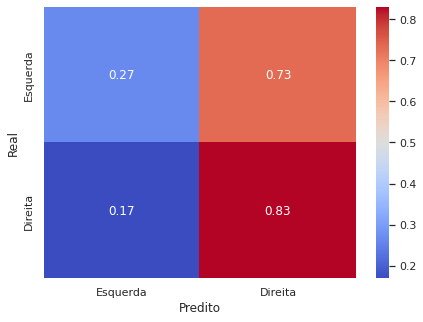

In [ ]:
classification_with_svm(X_23, y, 'scale', 1, 10)

###### Flesch reading ease + Gunning fog

In [ ]:
X_24 = df_readability.drop(['flesch-kincaid', 'dale-chall', 'bias', 'source', 'content'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_24, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.497368
1    0.01       scale         0.514912
2     0.1        auto         0.497368
3     0.1       scale         0.544434
4       1        auto         0.502571
5       1       scale         0.546189
6      10        auto         0.502571
7      10       scale         0.546189
8     100        auto         0.502571
9     100       scale         0.535783


In [ ]:
# C = 1, gamma = scale

              precision    recall  f1-score   support

        left       0.60      0.26      0.37       288
       right       0.53      0.83      0.65       289

    accuracy                           0.55       577
   macro avg       0.57      0.55      0.51       577
weighted avg       0.57      0.55      0.51       577



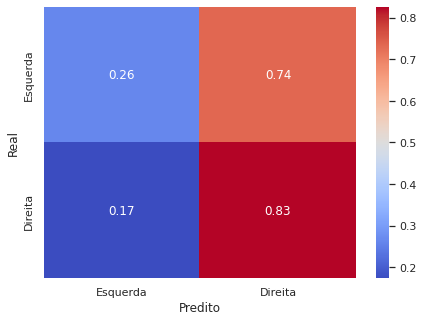

In [ ]:
classification_with_svm(X_24, y, 'scale', 1, 10)

###### Dale-Chall + Gunning fog

In [ ]:
X_34 = df_readability.drop(['flesch-kincaid', 'flesch-reading-ease', 'bias', 'source', 'content'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_34, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.504386
1    0.01       scale         0.514912
2     0.1        auto         0.504386
3     0.1       scale         0.542710
4       1        auto         0.469601
5       1       scale         0.551361
6      10        auto         0.467967
7      10       scale         0.547913
8     100        auto         0.474864
9     100       scale         0.528887


In [ ]:
# C = 1, gamma = scale

              precision    recall  f1-score   support

        left       0.59      0.26      0.37       288
       right       0.53      0.82      0.64       289

    accuracy                           0.54       577
   macro avg       0.56      0.54      0.50       577
weighted avg       0.56      0.54      0.50       577



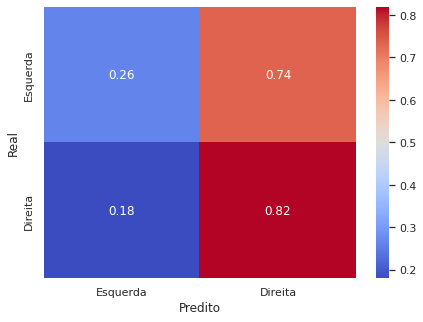

In [ ]:
classification_with_svm(X_34, y, 'scale', 0.1, 10)

##### 3 features

###### Flesch-Kincaid + Flesch reading ease + Dale-Chall
 

In [ ]:
X_123 = df_readability.drop(['gunning-fog', 'bias', 'source', 'content'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_123, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.495614
1    0.01       scale         0.514912
2     0.1        auto         0.495614
3     0.1       scale         0.544434
4       1        auto         0.492105
5       1       scale         0.544465
6      10        auto         0.492075
7      10       scale         0.547883
8     100        auto         0.492075
9     100       scale         0.539262


In [ ]:
# C = 10, gamma = scale

              precision    recall  f1-score   support

        left       0.61      0.26      0.36       288
       right       0.53      0.84      0.65       289

    accuracy                           0.55       577
   macro avg       0.57      0.55      0.51       577
weighted avg       0.57      0.55      0.51       577



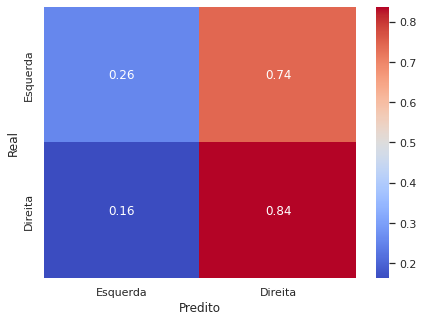

In [ ]:
classification_with_svm(X_123, y, 'scale', 10, 10)

###### Flesch-Kincaid + Flesch reading ease + Gunning fog

In [ ]:
X_124 = df_readability.drop(['dale-chall', 'bias', 'source', 'content'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_124, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.495614
1    0.01       scale         0.514912
2     0.1        auto         0.495614
3     0.1       scale         0.544434
4       1        auto         0.499093
5       1       scale         0.544465
6      10        auto         0.499093
7      10       scale         0.547852
8     100        auto         0.499093
9     100       scale         0.540986


In [ ]:
# C = 10, gamma = scale

              precision    recall  f1-score   support

        left       0.61      0.26      0.36       288
       right       0.53      0.84      0.65       289

    accuracy                           0.55       577
   macro avg       0.57      0.55      0.51       577
weighted avg       0.57      0.55      0.51       577



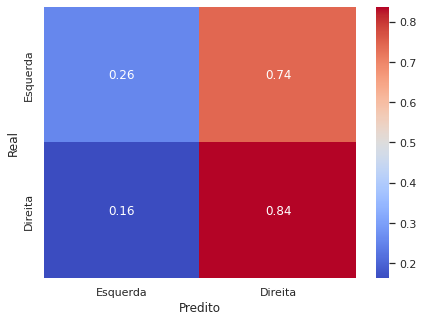

In [ ]:
classification_with_svm(X_124, y, 'scale', 10, 10)

###### Flesch-Kincaid  + Dale-Chall + Gunning fog

In [ ]:
X_134 = df_readability.drop(['flesch-reading-ease', 'bias', 'source', 'content'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_134, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.500877
1    0.01       scale         0.514912
2     0.1        auto         0.500877
3     0.1       scale         0.544434
4       1        auto         0.485209
5       1       scale         0.547913
6      10        auto         0.485178
7      10       scale         0.541016
8     100        auto         0.485178
9     100       scale         0.527193


In [ ]:
# C = 1, gamma = scale

              precision    recall  f1-score   support

        left       0.61      0.26      0.36       288
       right       0.53      0.83      0.65       289

    accuracy                           0.55       577
   macro avg       0.57      0.55      0.51       577
weighted avg       0.57      0.55      0.51       577



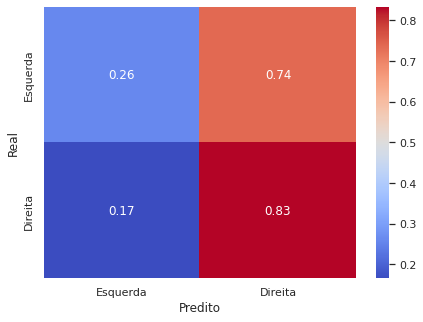

In [ ]:
classification_with_svm(X_134, y, 'scale', 1, 10)

###### Flesch reading ease + Dale-Chall + Gunning fog

In [ ]:
X_234 = df_readability.drop(['flesch-kincaid', 'bias', 'source', 'content'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_234, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.495614
1    0.01       scale         0.514912
2     0.1        auto         0.495614
3     0.1       scale         0.546158
4       1        auto         0.495644
5       1       scale         0.544465
6      10        auto         0.497368
7      10       scale         0.547883
8     100        auto         0.497368
9     100       scale         0.540986


In [ ]:
# C = 10, gamma = scale

              precision    recall  f1-score   support

        left       0.61      0.26      0.36       288
       right       0.53      0.84      0.65       289

    accuracy                           0.55       577
   macro avg       0.57      0.55      0.51       577
weighted avg       0.57      0.55      0.51       577



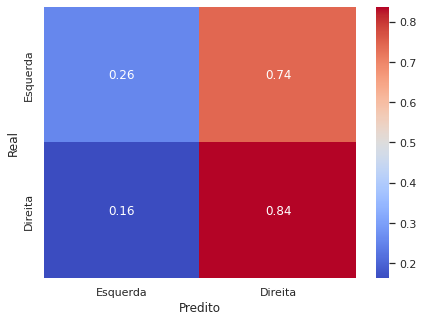

In [ ]:
classification_with_svm(X_234, y, 'scale', 10, 10)

##### 4 features

In [ ]:
X_1234 = df_readability.drop(['bias', 'source', 'content'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_1234, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.495614
1    0.01       scale         0.514912
2     0.1        auto         0.495614
3     0.1       scale         0.544434
4       1        auto         0.500817
5       1       scale         0.544465
6      10        auto         0.493890
7      10       scale         0.547852
8     100        auto         0.493890
9     100       scale         0.540986


In [ ]:
# C = 10, gamma = scale

              precision    recall  f1-score   support

        left       0.61      0.26      0.36       288
       right       0.53      0.84      0.65       289

    accuracy                           0.55       577
   macro avg       0.57      0.55      0.51       577
weighted avg       0.57      0.55      0.51       577



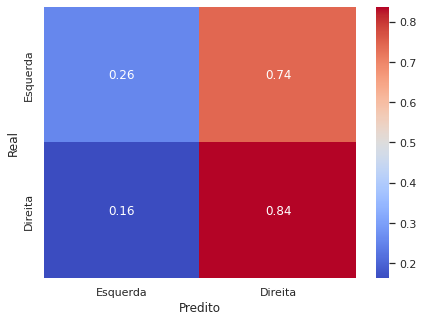

In [ ]:
classification_with_svm(X_1234, y, 'scale', 10, 10)

#### News July - Readability Features per Portal (Center-Left, Left, Right, Center-Right)

In [ ]:
df_portals_content_names = ["source", "content", "bias"]
df_portals_content = pd.DataFrame(columns = df_portals_content_names)
df_portals_content

,source,content,bias


In [ ]:
last_source = "berkeleyside"
df_portals_content = df_portals_content.append({'source': last_source, 'content': "", "bias": "left"}, ignore_index=True)

# add all news sources to dataframe 
for value in df_news_july.values:
  source = value[0]
  if value[3] == 'center':
    continue
  bias = value[3]
  if source != last_source:
    df_portals_content = df_portals_content.append({'source': source, 'content': "", "bias": bias}, ignore_index=True)
    last_source = source

df_portals_content

,source,content,bias
0,berkeleyside,,left
1,migrationpolicy,,left-center
2,deadline,,left-center
3,washingtonpress,,left
4,thehindubusinessline,,right-center
...,...,...,...
242,sun-sentinel,,right-center
243,tasnimnews,,right
244,nccivitas,,right
245,mexiconewsdaily,,left-center


In [ ]:
# add all news content to news sources 
for index, row in df_portals_content.iterrows():
  source = row['source']
  content = ""
  rows_1 = df_news_july[df_news_july['Source'] == source]
  for index_1, row_1 in rows_1.iterrows():
    content += preprocess(row_1['Content'])
  df_portals_content.at[index, 'content'] = content

df_portals_content

,source,content,bias
0,berkeleyside,when the homeowner did not voluntarily repair ...,left
1,migrationpolicy,mpis us immigration policy program analyzes us...,left-center
2,deadline,fifty years agoon may to be exactunited arti...,left-center
3,washingtonpress,k shares share this story a day after the unpr...,left
4,thehindubusinessline,a total of five girls of power generating comp...,right-center
...,...,...,...
242,sun-sentinel,renee steele rosomoff of hollywood florida for...,right-center
243,tasnimnews,at the moment we are forming bilateral meeting...,right
244,nccivitas,february by ray nothstine simple share butto...,right
245,mexiconewsdaily,a federal judge today ordered three former pem...,left-center


In [ ]:
df_readability_names = ["source", "content", "flesch-kincaid", "flesch-reading-ease", "dale-chall", "gunning-fog", "bias"]
df_readability = pd.DataFrame(columns = df_readability_names)
df_readability

,source,content,flesch-kincaid,flesch-reading-ease,dale-chall,gunning-fog,bias


In [ ]:
df_readability = pd.concat([df_portals_content, df_readability])
df_readability

,source,content,bias,flesch-kincaid,flesch-reading-ease,dale-chall,gunning-fog
0,berkeleyside,when the homeowner did not voluntarily repair ...,left,NaN,NaN,NaN,NaN
1,migrationpolicy,mpis us immigration policy program analyzes us...,left-center,NaN,NaN,NaN,NaN
2,deadline,fifty years agoon may to be exactunited arti...,left-center,NaN,NaN,NaN,NaN
3,washingtonpress,k shares share this story a day after the unpr...,left,NaN,NaN,NaN,NaN
4,thehindubusinessline,a total of five girls of power generating comp...,right-center,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
242,sun-sentinel,renee steele rosomoff of hollywood florida for...,right-center,NaN,NaN,NaN,NaN
243,tasnimnews,at the moment we are forming bilateral meeting...,right,NaN,NaN,NaN,NaN
244,nccivitas,february by ray nothstine simple share butto...,right,NaN,NaN,NaN,NaN
245,mexiconewsdaily,a federal judge today ordered three former pem...,left-center,NaN,NaN,NaN,NaN


In [ ]:
import textstat

for index, row in df_readability.iterrows():
  text = preprocess(row['content'])
  flesch_kincaid = textstat.flesch_kincaid_grade(text)
  flesch_reading = textstat.flesch_reading_ease(text)
  dale_chall = textstat.dale_chall_readability_score(text)
  gunning_fog = textstat.gunning_fog(text)
  df_readability.at[index, 'flesch-kincaid'] = flesch_kincaid
  df_readability.at[index, 'flesch-reading-ease'] = flesch_reading
  df_readability.at[index, 'dale-chall'] = dale_chall
  df_readability.at[index, 'gunning-fog'] = gunning_fog

In [ ]:
y = df_readability['bias']

##### 1 feature

###### Flesch-Kincaid

In [ ]:
X_1 = df_readability.drop(['flesch-reading-ease', 'dale-chall', 'gunning-fog', 'bias', 'source', 'content'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_1, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.259000
1    0.01       scale         0.251000
2     0.1        auto         0.259000
3     0.1       scale         0.304333
4       1        auto         0.283833
5       1       scale         0.267000
6      10        auto         0.288000
7      10       scale         0.266833
8     100        auto         0.288000
9     100       scale         0.319000


In [ ]:
# C = 100, gamma = scale

              precision    recall  f1-score   support

        left       0.42      0.30      0.35        63
 left-center       0.27      0.38      0.32        61
       right       0.30      0.29      0.30        62
right-center       0.33      0.31      0.32        61

    accuracy                           0.32       247
   macro avg       0.33      0.32      0.32       247
weighted avg       0.33      0.32      0.32       247



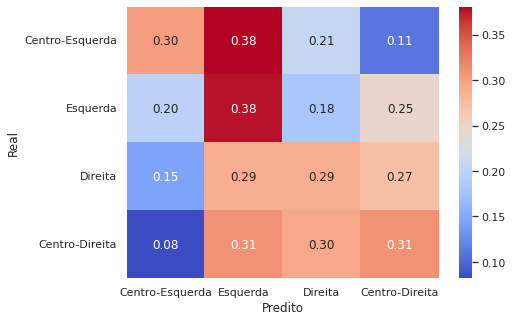

In [ ]:
classification_with_svm_4_classes(X_1, y, 'scale', 100, 10)

###### Flesch reading ease

In [ ]:
X_2 = df_readability.drop(['flesch-kincaid', 'dale-chall', 'gunning-fog', 'bias', 'source', 'content'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_2, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.251000
1    0.01       scale         0.251000
2     0.1        auto         0.251000
3     0.1       scale         0.304333
4       1        auto         0.267167
5       1       scale         0.267000
6      10        auto         0.267167
7      10       scale         0.266833
8     100        auto         0.267167
9     100       scale         0.323000


In [ ]:
# C = 100, gamma = scale

              precision    recall  f1-score   support

        left       0.42      0.30      0.35        63
 left-center       0.27      0.38      0.32        61
       right       0.31      0.31      0.31        62
right-center       0.33      0.31      0.32        61

    accuracy                           0.32       247
   macro avg       0.34      0.32      0.33       247
weighted avg       0.34      0.32      0.33       247



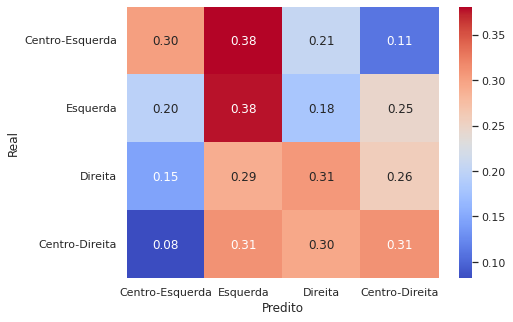

In [ ]:
classification_with_svm_4_classes(X_2, y, 'scale', 100, 10)

###### Dale-Chall 

In [ ]:
X_3 = df_readability.drop(['flesch-kincaid', 'flesch-reading-ease', 'gunning-fog', 'bias', 'source', 'content'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_3, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.259000
1    0.01       scale         0.251000
2     0.1        auto         0.259000
3     0.1       scale         0.304333
4       1        auto         0.300000
5       1       scale         0.267000
6      10        auto         0.295833
7      10       scale         0.270833
8     100        auto         0.291667
9     100       scale         0.319000


In [ ]:
# C = 100, gamma = scale

              precision    recall  f1-score   support

        left       0.42      0.30      0.35        63
 left-center       0.27      0.38      0.32        61
       right       0.30      0.29      0.30        62
right-center       0.33      0.31      0.32        61

    accuracy                           0.32       247
   macro avg       0.33      0.32      0.32       247
weighted avg       0.33      0.32      0.32       247



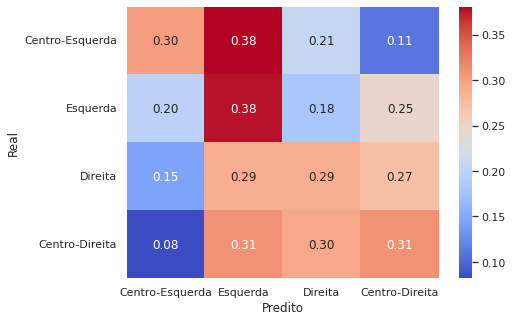

In [ ]:
classification_with_svm_4_classes(X_3, y, 'scale', 100, 10)

###### Gunning fog

In [ ]:
X_4 = df_readability.drop(['flesch-kincaid', 'flesch-reading-ease', 'dale-chall', 'bias', 'source', 'content'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_4, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.259000
1    0.01       scale         0.251000
2     0.1        auto         0.259000
3     0.1       scale         0.304333
4       1        auto         0.267667
5       1       scale         0.267000
6      10        auto         0.267667
7      10       scale         0.266833
8     100        auto         0.267667
9     100       scale         0.319000


In [ ]:
# C = 100, gamma = scale

              precision    recall  f1-score   support

        left       0.42      0.30      0.35        63
 left-center       0.27      0.38      0.32        61
       right       0.30      0.29      0.30        62
right-center       0.33      0.31      0.32        61

    accuracy                           0.32       247
   macro avg       0.33      0.32      0.32       247
weighted avg       0.33      0.32      0.32       247



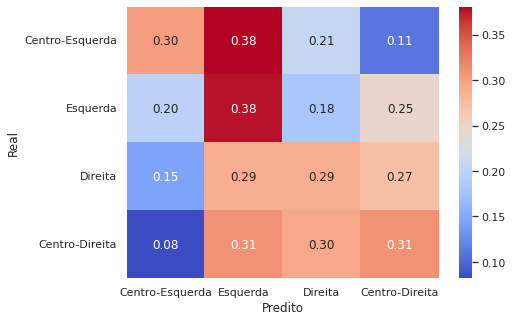

In [ ]:
classification_with_svm_4_classes(X_4, y, 'scale', 100, 10)

##### 2 features

###### Flesch-Kincaid + Flesch reading ease

In [ ]:
X_12 = df_readability.drop(['dale-chall', 'gunning-fog', 'bias', 'source', 'content'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_12, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.259000
1    0.01       scale         0.255000
2     0.1        auto         0.259000
3     0.1       scale         0.308000
4       1        auto         0.271167
5       1       scale         0.283500
6      10        auto         0.275333
7      10       scale         0.262667
8     100        auto         0.275333
9     100       scale         0.246833


In [ ]:
# C = 0.1, gamma = scale

              precision    recall  f1-score   support

        left       0.42      0.43      0.43        63
 left-center       0.00      0.00      0.00        61
       right       0.26      0.66      0.38        62
right-center       0.29      0.13      0.18        61

    accuracy                           0.31       247
   macro avg       0.24      0.31      0.25       247
weighted avg       0.24      0.31      0.25       247



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


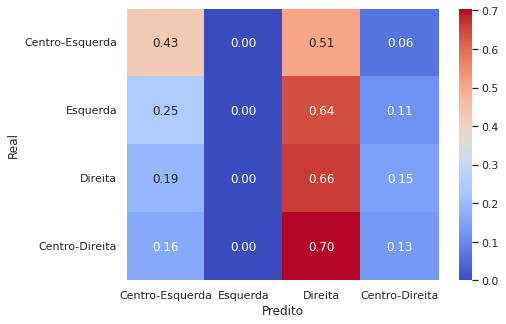

In [ ]:
classification_with_svm_4_classes(X_12, y, 'scale', 0.1, 10)

###### Flesch-Kincaid + Dale-Chall

In [ ]:
X_13 = df_readability.drop(['flesch-reading-ease', 'gunning-fog', 'bias', 'source', 'content'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_13, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.259000
1    0.01       scale         0.255000
2     0.1        auto         0.259000
3     0.1       scale         0.316333
4       1        auto         0.296167
5       1       scale         0.254833
6      10        auto         0.296167
7      10       scale         0.279333
8     100        auto         0.296167
9     100       scale         0.275167


In [ ]:
# C = 0.1, gamma = scale

              precision    recall  f1-score   support

        left       0.45      0.46      0.45        63
 left-center       0.00      0.00      0.00        61
       right       0.27      0.66      0.38        62
right-center       0.27      0.13      0.18        61

    accuracy                           0.32       247
   macro avg       0.25      0.31      0.25       247
weighted avg       0.25      0.32      0.26       247



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


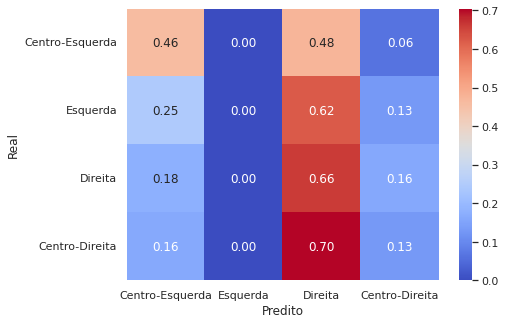

In [ ]:
classification_with_svm_4_classes(X_13, y, 'scale', 0.1, 10)

###### Flesch-Kincaid + Gunning fog

In [ ]:
X_14 = df_readability.drop(['flesch-reading-ease', 'dale-chall', 'bias', 'source', 'content'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_14, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.259000
1    0.01       scale         0.251000
2     0.1        auto         0.259000
3     0.1       scale         0.304333
4       1        auto         0.279833
5       1       scale         0.267000
6      10        auto         0.279833
7      10       scale         0.266833
8     100        auto         0.279833
9     100       scale         0.319000


In [ ]:
# C = 1, gamma = scale

              precision    recall  f1-score   support

        left       0.42      0.30      0.35        63
 left-center       0.27      0.38      0.32        61
       right       0.30      0.29      0.30        62
right-center       0.33      0.31      0.32        61

    accuracy                           0.32       247
   macro avg       0.33      0.32      0.32       247
weighted avg       0.33      0.32      0.32       247



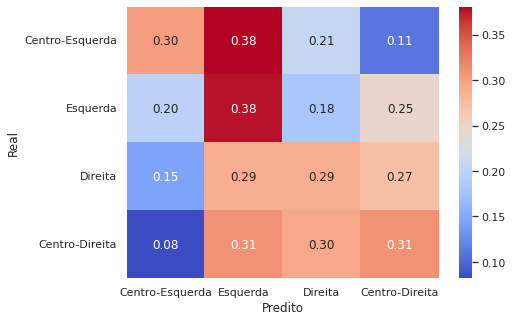

In [ ]:
classification_with_svm_4_classes(X_14, y, 'scale', 100, 10)

###### Flesch reading ease + Dale-Chall

In [ ]:
X_23 = df_readability.drop(['flesch-kincaid', 'gunning-fog', 'bias', 'source', 'content'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_23, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.259000
1    0.01       scale         0.259000
2     0.1        auto         0.259000
3     0.1       scale         0.320333
4       1        auto         0.275333
5       1       scale         0.255000
6      10        auto         0.275333
7      10       scale         0.275000
8     100        auto         0.275333
9     100       scale         0.263167


In [ ]:
# C = 1, gamma = scale

              precision    recall  f1-score   support

        left       0.45      0.46      0.45        63
 left-center       0.00      0.00      0.00        61
       right       0.27      0.68      0.39        62
right-center       0.28      0.13      0.18        61

    accuracy                           0.32       247
   macro avg       0.25      0.32      0.26       247
weighted avg       0.25      0.32      0.26       247



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


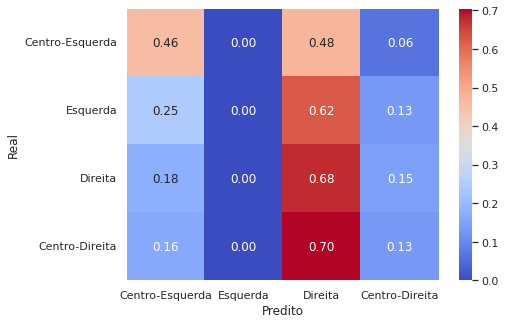

In [ ]:
classification_with_svm_4_classes(X_23, y, 'scale', 0.1, 10)

###### Flesch reading ease + Gunning fog

In [ ]:
X_24 = df_readability.drop(['flesch-kincaid', 'dale-chall', 'bias', 'source', 'content'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_24, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.247000
1    0.01       scale         0.255000
2     0.1        auto         0.259000
3     0.1       scale         0.308000
4       1        auto         0.259000
5       1       scale         0.283500
6      10        auto         0.263000
7      10       scale         0.262667
8     100        auto         0.263000
9     100       scale         0.259000


In [ ]:
# C = 1, gamma = scale

              precision    recall  f1-score   support

        left       0.42      0.43      0.43        63
 left-center       0.00      0.00      0.00        61
       right       0.26      0.66      0.38        62
right-center       0.29      0.13      0.18        61

    accuracy                           0.31       247
   macro avg       0.24      0.31      0.25       247
weighted avg       0.24      0.31      0.25       247



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


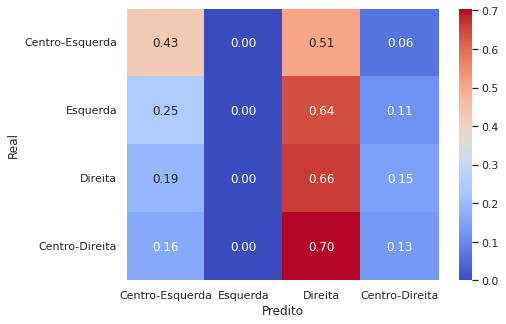

In [ ]:
classification_with_svm_4_classes(X_24, y, 'scale', 0.1, 10)

###### Dale-Chall + Gunning fog

In [ ]:
X_34 = df_readability.drop(['flesch-kincaid', 'flesch-reading-ease', 'bias', 'source', 'content'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_34, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.259000
1    0.01       scale         0.255000
2     0.1        auto         0.259000
3     0.1       scale         0.316333
4       1        auto         0.275833
5       1       scale         0.254833
6      10        auto         0.275833
7      10       scale         0.275333
8     100        auto         0.275833
9     100       scale         0.275167


In [ ]:
# C = 1, gamma = scale

              precision    recall  f1-score   support

        left       0.45      0.46      0.45        63
 left-center       0.00      0.00      0.00        61
       right       0.27      0.66      0.38        62
right-center       0.27      0.13      0.18        61

    accuracy                           0.32       247
   macro avg       0.25      0.31      0.25       247
weighted avg       0.25      0.32      0.26       247



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


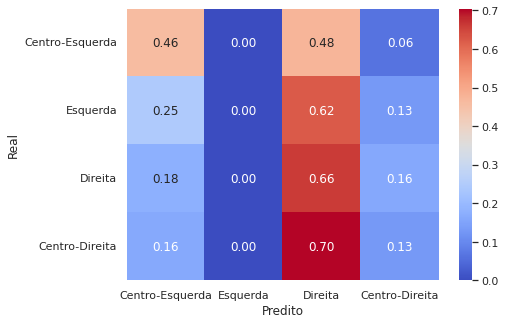

In [ ]:
classification_with_svm_4_classes(X_34, y, 'scale', 0.1, 10)

##### 3 features

###### Flesch-Kincaid + Flesch reading ease + Dale-Chall
 

In [ ]:
X_123 = df_readability.drop(['gunning-fog', 'bias', 'source', 'content'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_123, y)

  param_C param_gamma  mean_test_score
0    0.01        auto           0.2590
1    0.01       scale           0.2550
2     0.1        auto           0.2590
3     0.1       scale           0.3080
4       1        auto           0.2795
5       1       scale           0.2795
6      10        auto           0.2795
7      10       scale           0.2585
8     100        auto           0.2795
9     100       scale           0.2550


In [ ]:
# C = 1, gamma = scale

              precision    recall  f1-score   support

        left       0.42      0.43      0.42        63
 left-center       0.00      0.00      0.00        61
       right       0.26      0.66      0.38        62
right-center       0.30      0.13      0.18        61

    accuracy                           0.31       247
   macro avg       0.24      0.31      0.25       247
weighted avg       0.25      0.31      0.25       247



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


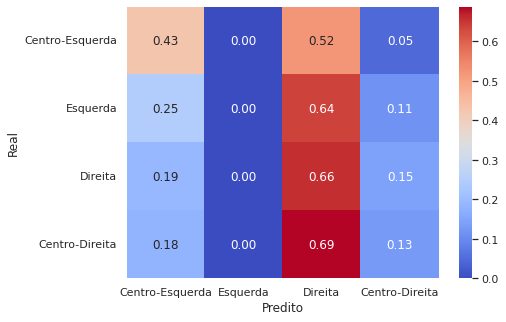

In [ ]:
classification_with_svm_4_classes(X_123, y, 'scale', 0.1, 10)

###### Flesch-Kincaid + Flesch reading ease + Gunning fog

In [ ]:
X_124 = df_readability.drop(['dale-chall', 'bias', 'source', 'content'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_124, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.259000
1    0.01       scale         0.255000
2     0.1        auto         0.259000
3     0.1       scale         0.308000
4       1        auto         0.271333
5       1       scale         0.275333
6      10        auto         0.271333
7      10       scale         0.258500
8     100        auto         0.271333
9     100       scale         0.259000


In [ ]:
# C = 0.1, gamma = scale

              precision    recall  f1-score   support

        left       0.42      0.43      0.42        63
 left-center       0.00      0.00      0.00        61
       right       0.26      0.66      0.38        62
right-center       0.30      0.13      0.18        61

    accuracy                           0.31       247
   macro avg       0.24      0.31      0.25       247
weighted avg       0.25      0.31      0.25       247



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


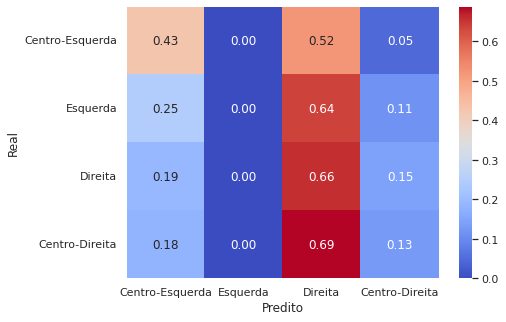

In [ ]:
classification_with_svm_4_classes(X_124, y, 'scale', 0.1, 10)

###### Flesch-Kincaid  + Dale-Chall + Gunning fog

In [ ]:
X_134 = df_readability.drop(['flesch-reading-ease', 'bias', 'source', 'content'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_134, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.259000
1    0.01       scale         0.255000
2     0.1        auto         0.259000
3     0.1       scale         0.316333
4       1        auto         0.279833
5       1       scale         0.254833
6      10        auto         0.275833
7      10       scale         0.279333
8     100        auto         0.275833
9     100       scale         0.275167


In [ ]:
# C = 0.1, gamma = scale

              precision    recall  f1-score   support

        left       0.45      0.46      0.45        63
 left-center       0.00      0.00      0.00        61
       right       0.27      0.66      0.38        62
right-center       0.27      0.13      0.18        61

    accuracy                           0.32       247
   macro avg       0.25      0.31      0.25       247
weighted avg       0.25      0.32      0.26       247



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


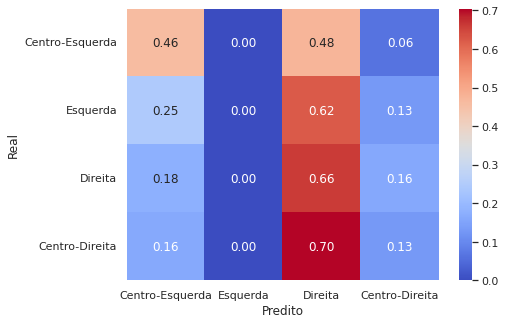

In [ ]:
classification_with_svm_4_classes(X_134, y, 'scale', 0.1, 10)

###### Flesch reading ease + Dale-Chall + Gunning fog

In [ ]:
X_234 = df_readability.drop(['flesch-kincaid', 'bias', 'source', 'content'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_234, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.259000
1    0.01       scale         0.255000
2     0.1        auto         0.259000
3     0.1       scale         0.308000
4       1        auto         0.271333
5       1       scale         0.279500
6      10        auto         0.279500
7      10       scale         0.258500
8     100        auto         0.279500
9     100       scale         0.255000


In [ ]:
# C = 1, gamma = scale

              precision    recall  f1-score   support

        left       0.42      0.43      0.42        63
 left-center       0.00      0.00      0.00        61
       right       0.26      0.66      0.38        62
right-center       0.30      0.13      0.18        61

    accuracy                           0.31       247
   macro avg       0.24      0.31      0.25       247
weighted avg       0.25      0.31      0.25       247



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


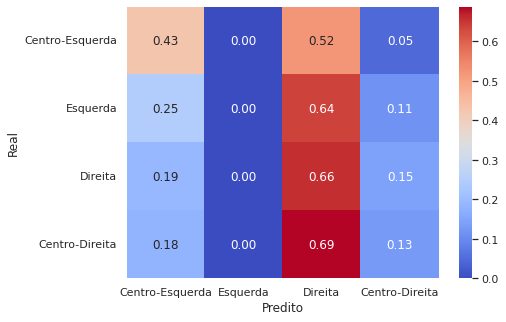

In [ ]:
classification_with_svm_4_classes(X_234, y, 'scale', 0.1, 10)

##### 4 features

In [ ]:
X_1234 = df_readability.drop(['bias', 'source', 'content'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_1234, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.259000
1    0.01       scale         0.255000
2     0.1        auto         0.259000
3     0.1       scale         0.308000
4       1        auto         0.271333
5       1       scale         0.275333
6      10        auto         0.275500
7      10       scale         0.258500
8     100        auto         0.275500
9     100       scale         0.255000


In [ ]:
# C = 0.1, gamma = scale

              precision    recall  f1-score   support

        left       0.42      0.43      0.42        63
 left-center       0.00      0.00      0.00        61
       right       0.26      0.66      0.38        62
right-center       0.30      0.13      0.18        61

    accuracy                           0.31       247
   macro avg       0.24      0.31      0.25       247
weighted avg       0.25      0.31      0.25       247



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


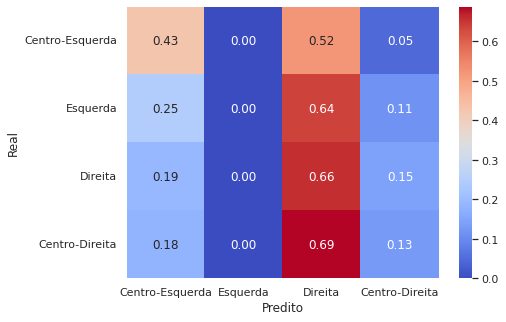

In [ ]:
classification_with_svm_4_classes(X_1234, y, 'scale', 0.1, 10)

#### News February - Readability Features per Portal (Center-Left, Left, Right, Center-Right)

In [ ]:
df_portals_content_names = ["source", "content", "bias"]
df_portals_content = pd.DataFrame(columns = df_portals_content_names)
df_portals_content

,source,content,bias


In [ ]:
last_source = "berkeleyside"
df_portals_content = df_portals_content.append({'source': last_source, 'content': "", "bias": "left"}, ignore_index=True)

# add all news sources to dataframe 
for value in df_news_february.values:
  source = value[0]
  if value[3] == 'center':
    continue
  bias = value[3]
  if source != last_source:
    df_portals_content = df_portals_content.append({'source': source, 'content': "", "bias": bias}, ignore_index=True)
    last_source = source

df_portals_content

,source,content,bias
0,berkeleyside,,left
1,motherjones.com,,left-center
2,politisite.com,,right
3,townhall.com,,right
4,historynewsnetwork.org,,left-center
...,...,...,...
571,thefederalist.com,,right
572,ir.net,,left
573,commdiginews.com,,right
574,crosscut.com,,left-center


In [ ]:
# add all news content to news sources 
for index, row in df_portals_content.iterrows():
  source = row['source']
  content = ""
  rows_1 = df_news_february[df_news_february['Source'] == source]
  for index_1, row_1 in rows_1.iterrows():
    content += preprocess(row_1['Content'])
  df_portals_content.at[index, 'content'] = content

df_portals_content

,source,content,bias
0,berkeleyside,,left
1,motherjones.com,welcome to the mother jones website please rea...,left-center
2,politisite.com,west lafayette ind a video on social media sho...,right
3,townhall.com,top dem is not satisfied with white houses new...,right
4,historynewsnetwork.org,james robenaltis a presidential historian auth...,left-center
...,...,...,...
571,thefederalist.com,following the model of the us house democrats ...,right
572,ir.net,share boy do times change and so do the storie...,left
573,commdiginews.com,washington one of the biggest successes of th...,right
574,crosscut.com,i couldnt do everything to become an ethical c...,left-center


In [ ]:
df_readability_names = ["source", "content", "flesch-kincaid", "flesch-reading-ease", "dale-chall", "gunning-fog", "bias"]
df_readability = pd.DataFrame(columns = df_readability_names)
df_readability

,source,content,flesch-kincaid,flesch-reading-ease,dale-chall,gunning-fog,bias


In [ ]:
df_readability = pd.concat([df_portals_content, df_readability])
df_readability

,source,content,bias,flesch-kincaid,flesch-reading-ease,dale-chall,gunning-fog
0,berkeleyside,,left,NaN,NaN,NaN,NaN
1,motherjones.com,welcome to the mother jones website please rea...,left-center,NaN,NaN,NaN,NaN
2,politisite.com,west lafayette ind a video on social media sho...,right,NaN,NaN,NaN,NaN
3,townhall.com,top dem is not satisfied with white houses new...,right,NaN,NaN,NaN,NaN
4,historynewsnetwork.org,james robenaltis a presidential historian auth...,left-center,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
571,thefederalist.com,following the model of the us house democrats ...,right,NaN,NaN,NaN,NaN
572,ir.net,share boy do times change and so do the storie...,left,NaN,NaN,NaN,NaN
573,commdiginews.com,washington one of the biggest successes of th...,right,NaN,NaN,NaN,NaN
574,crosscut.com,i couldnt do everything to become an ethical c...,left-center,NaN,NaN,NaN,NaN


In [ ]:
import textstat

for index, row in df_readability.iterrows():
  text = preprocess(row['content'])
  flesch_kincaid = textstat.flesch_kincaid_grade(text)
  flesch_reading = textstat.flesch_reading_ease(text)
  dale_chall = textstat.dale_chall_readability_score(text)
  gunning_fog = textstat.gunning_fog(text)
  df_readability.at[index, 'flesch-kincaid'] = flesch_kincaid
  df_readability.at[index, 'flesch-reading-ease'] = flesch_reading
  df_readability.at[index, 'dale-chall'] = dale_chall
  df_readability.at[index, 'gunning-fog'] = gunning_fog

In [ ]:
y = df_readability['bias']

##### 1 feature

###### Flesch-Kincaid

In [ ]:
X_1 = df_readability.drop(['flesch-reading-ease', 'dale-chall', 'gunning-fog', 'bias', 'source', 'content'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_1, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.244797
1    0.01       scale         0.269328
2     0.1        auto         0.244797
3     0.1       scale         0.272777
4       1        auto         0.235904
5       1       scale         0.255414
6      10        auto         0.234150
7      10       scale         0.251785
8     100        auto         0.234150
9     100       scale         0.264035


In [ ]:
# C = 100, gamma = scale

              precision    recall  f1-score   support

        left       0.32      0.10      0.16       144
 left-center       0.30      0.18      0.23       144
       right       0.26      0.24      0.25       144
right-center       0.26      0.56      0.36       144

    accuracy                           0.27       576
   macro avg       0.29      0.27      0.25       576
weighted avg       0.29      0.27      0.25       576



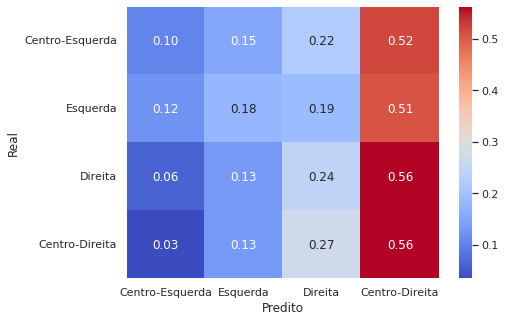

In [ ]:
classification_with_svm_4_classes(X_1, y, 'scale', 0.1, 10)

###### Flesch reading ease

In [ ]:
X_2 = df_readability.drop(['flesch-kincaid', 'dale-chall', 'gunning-fog', 'bias', 'source', 'content'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_2, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.248185
1    0.01       scale         0.269328
2     0.1        auto         0.248185
3     0.1       scale         0.272777
4       1        auto         0.251603
5       1       scale         0.255414
6      10        auto         0.251603
7      10       scale         0.251785
8     100        auto         0.251603
9     100       scale         0.264035


In [ ]:
# C = 100, gamma = scale

              precision    recall  f1-score   support

        left       0.32      0.10      0.16       144
 left-center       0.30      0.18      0.23       144
       right       0.26      0.24      0.25       144
right-center       0.26      0.56      0.36       144

    accuracy                           0.27       576
   macro avg       0.29      0.27      0.25       576
weighted avg       0.29      0.27      0.25       576



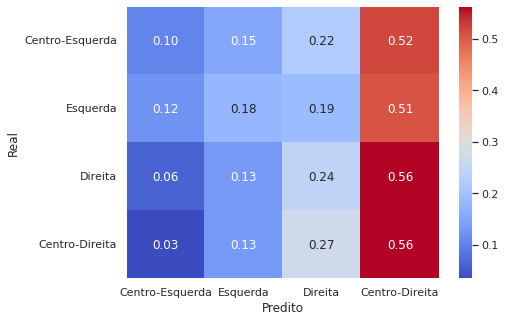

In [ ]:
classification_with_svm_4_classes(X_2, y, 'scale', 0.1, 10)

###### Dale-Chall 

In [ ]:
X_3 = df_readability.drop(['flesch-kincaid', 'flesch-reading-ease', 'gunning-fog', 'bias', 'source', 'content'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_3, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.244797
1    0.01       scale         0.269328
2     0.1        auto         0.244797
3     0.1       scale         0.272777
4       1        auto         0.277647
5       1       scale         0.255414
6      10        auto         0.275892
7      10       scale         0.251785
8     100        auto         0.282789
9     100       scale         0.264035


In [ ]:
# C = 100, gamma = scale

              precision    recall  f1-score   support

        left       0.26      0.42      0.32       144
 left-center       0.30      0.22      0.26       144
       right       0.29      0.22      0.25       144
right-center       0.30      0.26      0.28       144

    accuracy                           0.28       576
   macro avg       0.29      0.28      0.28       576
weighted avg       0.29      0.28      0.28       576



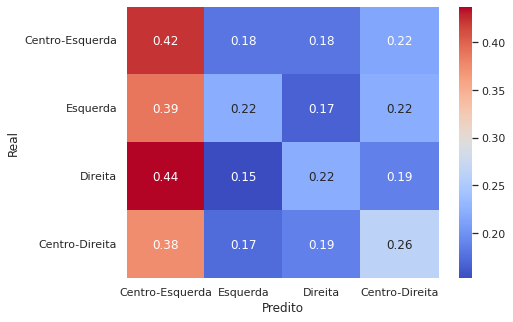

In [ ]:
classification_with_svm_4_classes(X_3, y, 'auto', 100, 10)

###### Gunning fog

In [ ]:
X_4 = df_readability.drop(['flesch-kincaid', 'flesch-reading-ease', 'dale-chall', 'bias', 'source', 'content'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_4, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.229159
1    0.01       scale         0.269328
2     0.1        auto         0.229159
3     0.1       scale         0.272777
4       1        auto         0.244676
5       1       scale         0.255414
6      10        auto         0.248155
7      10       scale         0.251785
8     100        auto         0.253327
9     100       scale         0.265789


In [ ]:
# C = 100, gamma = scale

              precision    recall  f1-score   support

        left       0.32      0.10      0.16       144
 left-center       0.30      0.18      0.23       144
       right       0.26      0.24      0.25       144
right-center       0.26      0.56      0.36       144

    accuracy                           0.27       576
   macro avg       0.29      0.27      0.25       576
weighted avg       0.29      0.27      0.25       576



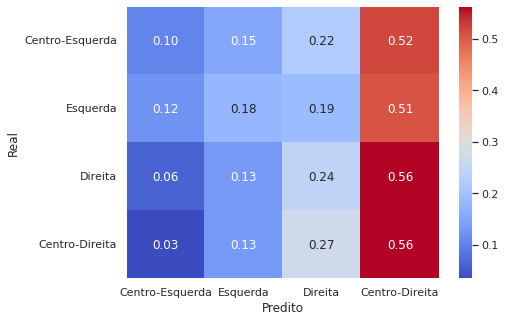

In [ ]:
classification_with_svm_4_classes(X_4, y, 'scale', 0.1, 10)

##### 2 features

###### Flesch-Kincaid + Flesch reading ease

In [ ]:
X_12 = df_readability.drop(['dale-chall', 'gunning-fog', 'bias', 'source', 'content'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_12, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.244797
1    0.01       scale         0.269238
2     0.1        auto         0.244797
3     0.1       scale         0.274410
4       1        auto         0.255203
5       1       scale         0.257078
6      10        auto         0.260375
7      10       scale         0.253539
8     100        auto         0.260375
9     100       scale         0.250060


In [ ]:
# C = 0.1, gamma = scale

              precision    recall  f1-score   support

        left       0.31      0.08      0.12       144
 left-center       0.32      0.17      0.23       144
       right       0.25      0.27      0.26       144
right-center       0.27      0.58      0.37       144

    accuracy                           0.27       576
   macro avg       0.29      0.27      0.24       576
weighted avg       0.29      0.27      0.24       576



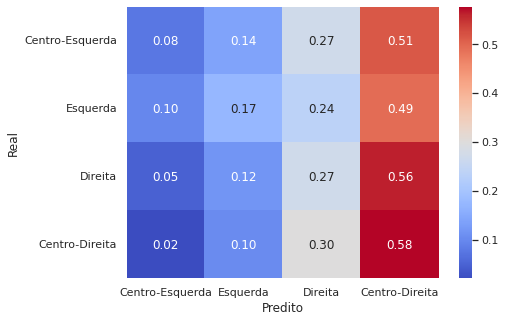

In [ ]:
classification_with_svm_4_classes(X_12, y, 'scale', 0.1, 10)

###### Flesch-Kincaid + Dale-Chall

In [ ]:
X_13 = df_readability.drop(['flesch-reading-ease', 'gunning-fog', 'bias', 'source', 'content'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_13, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.241168
1    0.01       scale         0.265789
2     0.1        auto         0.241168
3     0.1       scale         0.267483
4       1        auto         0.242892
5       1       scale         0.255445
6      10        auto         0.237659
7      10       scale         0.256987
8     100        auto         0.239413
9     100       scale         0.251785


In [ ]:
# C = 0.1, gamma = scale

              precision    recall  f1-score   support

        left       0.33      0.09      0.14       144
 left-center       0.29      0.17      0.22       144
       right       0.26      0.24      0.25       144
right-center       0.26      0.56      0.35       144

    accuracy                           0.27       576
   macro avg       0.28      0.27      0.24       576
weighted avg       0.28      0.27      0.24       576



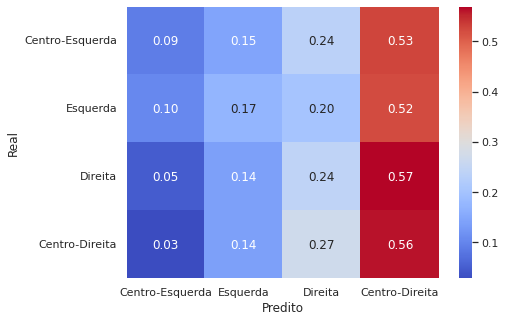

In [ ]:
classification_with_svm_4_classes(X_13, y, 'scale', 0.1, 10)

###### Flesch-Kincaid + Gunning fog

In [ ]:
X_14 = df_readability.drop(['flesch-reading-ease', 'dale-chall', 'bias', 'source', 'content'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_14, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.236025
1    0.01       scale         0.269328
2     0.1        auto         0.236025
3     0.1       scale         0.272777
4       1        auto         0.244676
5       1       scale         0.255414
6      10        auto         0.239504
7      10       scale         0.251785
8     100        auto         0.239504
9     100       scale         0.264035


In [ ]:
# C = 1, gamma = scale

              precision    recall  f1-score   support

        left       0.32      0.10      0.16       144
 left-center       0.30      0.18      0.23       144
       right       0.26      0.24      0.25       144
right-center       0.26      0.56      0.36       144

    accuracy                           0.27       576
   macro avg       0.29      0.27      0.25       576
weighted avg       0.29      0.27      0.25       576



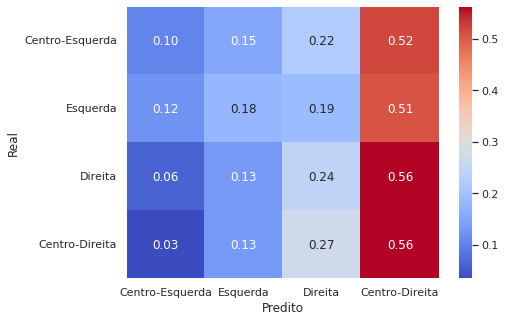

In [ ]:
classification_with_svm_4_classes(X_14, y, 'scale', 0.1, 10)

###### Flesch reading ease + Dale-Chall

In [ ]:
X_23 = df_readability.drop(['flesch-kincaid', 'gunning-fog', 'bias', 'source', 'content'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_23, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.248276
1    0.01       scale         0.267514
2     0.1        auto         0.248276
3     0.1       scale         0.269238
4       1        auto         0.256897
5       1       scale         0.258893
6      10        auto         0.255172
7      10       scale         0.258772
8     100        auto         0.255172
9     100       scale         0.251785


In [ ]:
# C = 1, gamma = scale

              precision    recall  f1-score   support

        left       0.31      0.08      0.12       144
 left-center       0.31      0.18      0.23       144
       right       0.25      0.24      0.25       144
right-center       0.26      0.58      0.36       144

    accuracy                           0.27       576
   macro avg       0.28      0.27      0.24       576
weighted avg       0.28      0.27      0.24       576



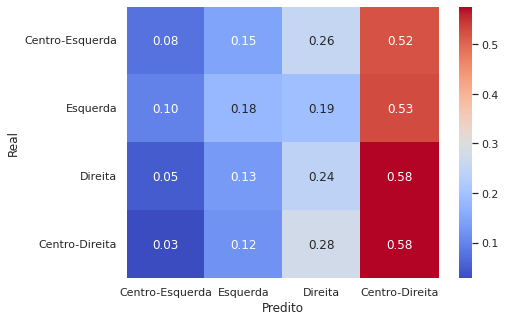

In [ ]:
classification_with_svm_4_classes(X_23, y, 'scale', 0.1, 10)

###### Flesch reading ease + Gunning fog

In [ ]:
X_24 = df_readability.drop(['flesch-kincaid', 'dale-chall', 'bias', 'source', 'content'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_24, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.244797
1    0.01       scale         0.269238
2     0.1        auto         0.244797
3     0.1       scale         0.274410
4       1        auto         0.258621
5       1       scale         0.257078
6      10        auto         0.256897
7      10       scale         0.253539
8     100        auto         0.256897
9     100       scale         0.251785


In [ ]:
# C = 1, gamma = scale

              precision    recall  f1-score   support

        left       0.31      0.08      0.12       144
 left-center       0.32      0.17      0.23       144
       right       0.25      0.27      0.26       144
right-center       0.27      0.58      0.37       144

    accuracy                           0.27       576
   macro avg       0.29      0.27      0.24       576
weighted avg       0.29      0.27      0.24       576



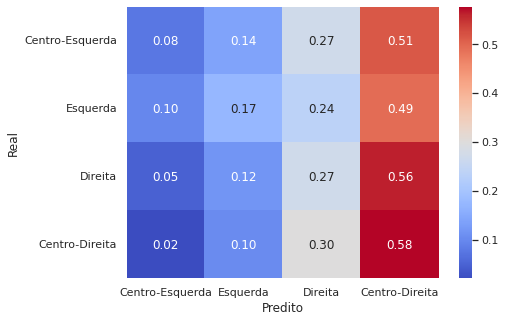

In [ ]:
classification_with_svm_4_classes(X_24, y, 'scale', 0.1, 10)

###### Dale-Chall + Gunning fog

In [ ]:
X_34 = df_readability.drop(['flesch-kincaid', 'flesch-reading-ease', 'bias', 'source', 'content'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_34, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.241319
1    0.01       scale         0.265789
2     0.1        auto         0.241319
3     0.1       scale         0.267483
4       1        auto         0.243013
5       1       scale         0.255445
6      10        auto         0.244676
7      10       scale         0.255263
8     100        auto         0.244676
9     100       scale         0.251785


In [ ]:
# C = 1, gamma = scale

              precision    recall  f1-score   support

        left       0.33      0.09      0.14       144
 left-center       0.29      0.17      0.22       144
       right       0.26      0.24      0.25       144
right-center       0.26      0.56      0.35       144

    accuracy                           0.27       576
   macro avg       0.28      0.27      0.24       576
weighted avg       0.28      0.27      0.24       576



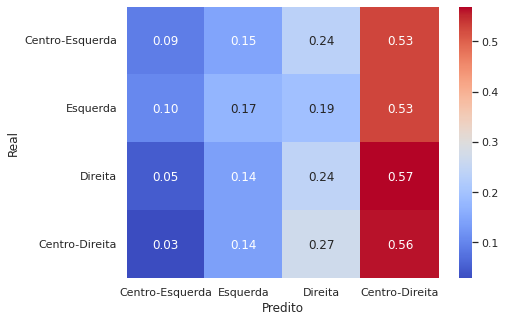

In [ ]:
classification_with_svm_4_classes(X_34, y, 'scale', 0.1, 10)

##### 3 features

###### Flesch-Kincaid + Flesch reading ease + Dale-Chall
 

In [ ]:
X_123 = df_readability.drop(['gunning-fog', 'bias', 'source', 'content'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_123, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.244797
1    0.01       scale         0.269238
2     0.1        auto         0.244797
3     0.1       scale         0.274410
4       1        auto         0.262099
5       1       scale         0.257078
6      10        auto         0.260345
7      10       scale         0.258802
8     100        auto         0.260345
9     100       scale         0.251815


In [ ]:
# C = 1, gamma = scale

              precision    recall  f1-score   support

        left       0.32      0.08      0.12       144
 left-center       0.32      0.17      0.23       144
       right       0.25      0.27      0.26       144
right-center       0.27      0.58      0.37       144

    accuracy                           0.27       576
   macro avg       0.29      0.27      0.24       576
weighted avg       0.29      0.27      0.24       576



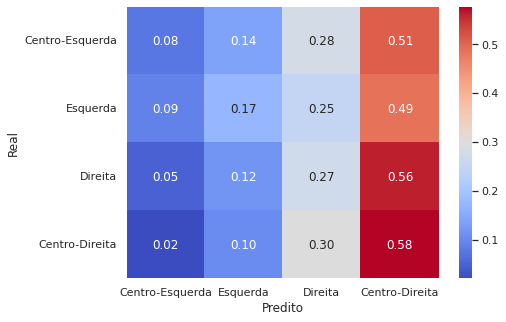

In [ ]:
classification_with_svm_4_classes(X_123, y, 'scale', 0.1, 10)

###### Flesch-Kincaid + Flesch reading ease + Gunning fog

In [ ]:
X_124 = df_readability.drop(['dale-chall', 'bias', 'source', 'content'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_124, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.244797
1    0.01       scale         0.272747
2     0.1        auto         0.244797
3     0.1       scale         0.276195
4       1        auto         0.256897
5       1       scale         0.253630
6      10        auto         0.256897
7      10       scale         0.258832
8     100        auto         0.256897
9     100       scale         0.251815


In [ ]:
# C = 0.1, gamma = scale

              precision    recall  f1-score   support

        left       0.33      0.08      0.12       144
 left-center       0.34      0.18      0.24       144
       right       0.25      0.27      0.26       144
right-center       0.27      0.58      0.37       144

    accuracy                           0.28       576
   macro avg       0.30      0.28      0.25       576
weighted avg       0.30      0.28      0.25       576



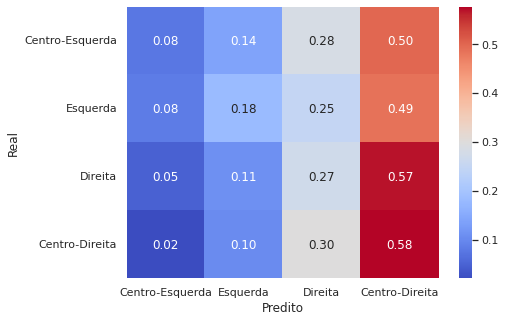

In [ ]:
classification_with_svm_4_classes(X_124, y, 'scale', 0.1, 10)

###### Flesch-Kincaid  + Dale-Chall + Gunning fog

In [ ]:
X_134 = df_readability.drop(['flesch-reading-ease', 'bias', 'source', 'content'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_134, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.234301
1    0.01       scale         0.264035
2     0.1        auto         0.234301
3     0.1       scale         0.265729
4       1        auto         0.239413
5       1       scale         0.253660
6      10        auto         0.235965
7      10       scale         0.253569
8     100        auto         0.235965
9     100       scale         0.239685


In [ ]:
# C = 0.1, gamma = scale

              precision    recall  f1-score   support

        left       0.33      0.10      0.15       144
 left-center       0.29      0.17      0.22       144
       right       0.25      0.23      0.24       144
right-center       0.26      0.56      0.35       144

    accuracy                           0.27       576
   macro avg       0.28      0.27      0.24       576
weighted avg       0.28      0.27      0.24       576



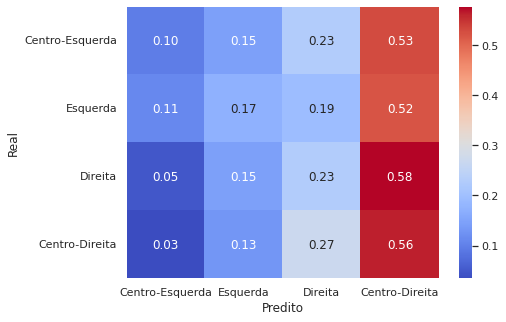

In [ ]:
classification_with_svm_4_classes(X_134, y, 'scale', 0.1, 10)

###### Flesch reading ease + Dale-Chall + Gunning fog

In [ ]:
X_234 = df_readability.drop(['flesch-kincaid', 'bias', 'source', 'content'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_234, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.244797
1    0.01       scale         0.269238
2     0.1        auto         0.244797
3     0.1       scale         0.274410
4       1        auto         0.258651
5       1       scale         0.255354
6      10        auto         0.258651
7      10       scale         0.260557
8     100        auto         0.258651
9     100       scale         0.251815


In [ ]:
# C = 1, gamma = scale

              precision    recall  f1-score   support

        left       0.32      0.08      0.12       144
 left-center       0.32      0.17      0.23       144
       right       0.25      0.27      0.26       144
right-center       0.27      0.58      0.37       144

    accuracy                           0.27       576
   macro avg       0.29      0.27      0.24       576
weighted avg       0.29      0.27      0.24       576



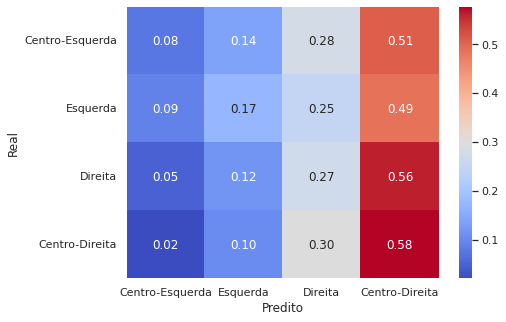

In [ ]:
classification_with_svm_4_classes(X_234, y, 'scale', 0.1, 10)

##### 4 features

In [ ]:
X_1234 = df_readability.drop(['bias', 'source', 'content'], axis=1)

In [ ]:
grid_search_cv_with_svm(X_1234, y)

  param_C param_gamma  mean_test_score
0    0.01        auto         0.246521
1    0.01       scale         0.272747
2     0.1        auto         0.246521
3     0.1       scale         0.276195
4       1        auto         0.258651
5       1       scale         0.253630
6      10        auto         0.260375
7      10       scale         0.258832
8     100        auto         0.260375
9     100       scale         0.251815


In [ ]:
# C = 0.1, gamma = scale

              precision    recall  f1-score   support

        left       0.33      0.08      0.12       144
 left-center       0.34      0.18      0.24       144
       right       0.25      0.27      0.26       144
right-center       0.27      0.58      0.37       144

    accuracy                           0.28       576
   macro avg       0.30      0.28      0.25       576
weighted avg       0.30      0.28      0.25       576



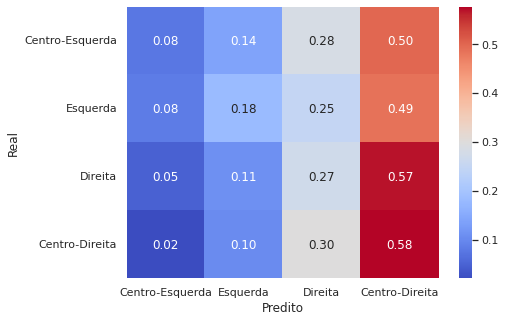

In [ ]:
classification_with_svm_4_classes(X_1234, y, 'scale', 0.1, 10)

### 5. Information Theory Approach 

#### News July

##### 5.3.1. Computar importância de todos os termos e descartar os de menor frequência

In [22]:
corpus_news_aggregator_left = ""
corpus_news_aggregator_left_center = ""
corpus_news_aggregator_right = ""
corpus_news_aggregator_right_center = ""
        
for value in df_news_july.values:
  text = value[2]
  bias = value[3]
  if "left-center" in bias:
    corpus_news_aggregator_left += preprocess(text)
  elif "left" in bias:
    corpus_news_aggregator_left_center += preprocess(text)
  if "right-center" in bias:
    corpus_news_aggregator_right_center += preprocess(text)
  elif "right" in bias:
    corpus_news_aggregator_right += preprocess(text)

In [23]:
bag_of_words_news_aggregator_left = corpus_news_aggregator_left.split(' ')

In [24]:
bag_of_words_news_aggregator_left_center = corpus_news_aggregator_left_center.split(' ')

In [25]:
bag_of_words_news_aggregator_right = corpus_news_aggregator_right.split(' ')

In [26]:
bag_of_words_news_aggregator_right_center = corpus_news_aggregator_right_center.split(' ')

In [27]:
bag_of_words_extreme = set(bag_of_words_news_aggregator_left).union(set(bag_of_words_news_aggregator_right))
bag_of_words_moderate = set(bag_of_words_news_aggregator_left_center).union(set(bag_of_words_news_aggregator_right_center))
bag_of_words = set(bag_of_words_extreme).union(set(bag_of_words_moderate))

In [29]:
number_of_words_left = dict.fromkeys(bag_of_words, 0)
for word in bag_of_words_news_aggregator_left:
    number_of_words_left[word] += 1
df_left = pd.DataFrame(list(number_of_words_left.items()),columns = ['word','occ-left'])

number_of_words_left_center = dict.fromkeys(bag_of_words, 0)
for word in bag_of_words_news_aggregator_left_center:
    number_of_words_left_center[word] += 1
df_left_center = pd.DataFrame(list(number_of_words_left_center.items()),columns = ['word','occ-left-center'])

number_of_words_right = dict.fromkeys(bag_of_words, 0)
for word in bag_of_words_news_aggregator_right:
    number_of_words_right[word] += 1
df_right = pd.DataFrame(list(number_of_words_right.items()),columns = ['word','occ-right'])

number_of_words_right_center = dict.fromkeys(bag_of_words, 0)
for word in bag_of_words_news_aggregator_right_center:
    number_of_words_right_center[word] += 1
df_right_center = pd.DataFrame(list(number_of_words_right_center.items()),columns = ['word','occ-right-center'])

df_words_extreme = pd.merge(df_left, df_right, on='word')
df_words_moderate = pd.merge(df_left_center, df_right_center, on='word')
df_words = pd.merge(df_words_extreme, df_words_moderate, on='word')
df_words

,word,occ-left,occ-right,occ-left-center,occ-right-center
0,,20754,12847,18825,22270
1,ebrahim,0,1,0,1
2,taxesjust,0,0,1,0
3,indy,3,0,0,0
4,pressontario,1,0,0,0
...,...,...,...,...,...
94142,substantial,35,18,40,20
94143,moussed,0,0,2,0
94144,oxybenzone,1,0,0,0
94145,plenkovic,1,0,0,0


In [30]:
index = df_words[ df_words['occ-left'] + df_words['occ-right'] + df_words['occ-left-center'] + df_words['occ-right-center'] < 10 ].index
df_words.drop(index, inplace = True)
df_words

,word,occ-left,occ-right,occ-left-center,occ-right-center
0,,20754,12847,18825,22270
27,setback,10,0,3,4
32,womans,9,24,30,11
33,gunfire,6,5,4,1
36,capandtrade,0,1,20,0
...,...,...,...,...,...
94136,demeaning,0,9,5,0
94137,superintendents,4,2,1,9
94138,ah,2,17,4,8
94140,mon,28,1,0,0


##### 5.3.2. Construção da função de probabilidade do termo t sobre as classes

In [31]:
pd.options.mode.chained_assignment = None  # default='warn'

df_words['perc-left'] = 0.0
df_words['perc-left-center'] = 0.0
df_words['perc-right'] = 0.0
df_words['perc-right-center'] = 0.0

for i in df_words.index:
  total = df_words['occ-left'][i] + df_words['occ-right'][i] + df_words['occ-left-center'][i] + df_words['occ-right-center'][i]
  df_words['perc-left'][i] = round(float(df_words['occ-left'][i] / total), 3)
  df_words['perc-left-center'][i] = round(float(df_words['occ-left-center'][i] / total), 3)
  df_words['perc-right'][i] = round(float(df_words['occ-right'][i] / total), 3)
  df_words['perc-right-center'][i] = round(float(df_words['occ-right-center'][i] / total), 3)

df_words

,word,occ-left,occ-right,occ-left-center,occ-right-center,perc-left,perc-left-center,perc-right,perc-right-center
0,,20754,12847,18825,22270,0.278,0.252,0.172,0.298
27,setback,10,0,3,4,0.588,0.176,0.000,0.235
32,womans,9,24,30,11,0.122,0.405,0.324,0.149
33,gunfire,6,5,4,1,0.375,0.250,0.312,0.062
36,capandtrade,0,1,20,0,0.000,0.952,0.048,0.000
...,...,...,...,...,...,...,...,...,...
94136,demeaning,0,9,5,0,0.000,0.357,0.643,0.000
94137,superintendents,4,2,1,9,0.250,0.062,0.125,0.562
94138,ah,2,17,4,8,0.065,0.129,0.548,0.258
94140,mon,28,1,0,0,0.966,0.000,0.034,0.000


##### 5.3.3. Calcular a entropia de cada termo

In [32]:
df_words['shannon-entropy'] = 0.0
df_words

,word,occ-left,occ-right,occ-left-center,occ-right-center,perc-left,perc-left-center,perc-right,perc-right-center,shannon-entropy
0,,20754,12847,18825,22270,0.278,0.252,0.172,0.298,0.0
27,setback,10,0,3,4,0.588,0.176,0.000,0.235,0.0
32,womans,9,24,30,11,0.122,0.405,0.324,0.149,0.0
33,gunfire,6,5,4,1,0.375,0.250,0.312,0.062,0.0
36,capandtrade,0,1,20,0,0.000,0.952,0.048,0.000,0.0
...,...,...,...,...,...,...,...,...,...,...
94136,demeaning,0,9,5,0,0.000,0.357,0.643,0.000,0.0
94137,superintendents,4,2,1,9,0.250,0.062,0.125,0.562,0.0
94138,ah,2,17,4,8,0.065,0.129,0.548,0.258,0.0
94140,mon,28,1,0,0,0.966,0.000,0.034,0.000,0.0


In [33]:
from scipy.stats import entropy

def calculate_shannon_entropy(p):
  return entropy(p, base=2)

In [34]:
df_words['shannon-entropy'] = 0.0

for i in df_words.index:
  shannon_entropy = round(calculate_shannon_entropy([df_words['perc-left'][i], df_words['perc-right'][i], df_words['perc-left-center'][i], df_words['perc-right-center'][i]]), 3)
  df_words['shannon-entropy'][i] = shannon_entropy

df_words

,word,occ-left,occ-right,occ-left-center,occ-right-center,perc-left,perc-left-center,perc-right,perc-right-center,shannon-entropy
0,,20754,12847,18825,22270,0.278,0.252,0.172,0.298,1.972
27,setback,10,0,3,4,0.588,0.176,0.000,0.235,1.383
32,womans,9,24,30,11,0.122,0.405,0.324,0.149,1.834
33,gunfire,6,5,4,1,0.375,0.250,0.312,0.062,1.804
36,capandtrade,0,1,20,0,0.000,0.952,0.048,0.000,0.278
...,...,...,...,...,...,...,...,...,...,...
94136,demeaning,0,9,5,0,0.000,0.357,0.643,0.000,0.940
94137,superintendents,4,2,1,9,0.250,0.062,0.125,0.562,1.591
94138,ah,2,17,4,8,0.065,0.129,0.548,0.258,1.617
94140,mon,28,1,0,0,0.966,0.000,0.034,0.000,0.214


In [35]:
df_trump = df_words.loc[df_words['word'] == 'trump']
df_trump

,word,occ-left,occ-right,occ-left-center,occ-right-center,perc-left,perc-left-center,perc-right,perc-right-center,shannon-entropy
51988,trump,697,1802,3254,641,0.109,0.509,0.282,0.1,1.692


In [36]:
df_soros = df_words.loc[df_words['word'] == 'soros']
df_soros

,word,occ-left,occ-right,occ-left-center,occ-right-center,perc-left,perc-left-center,perc-right,perc-right-center,shannon-entropy
80085,soros,2,38,2,0,0.048,0.048,0.905,0.0,0.552


##### 5.3.4. Selecionar vocabulário de referência

In [37]:
#df_reference_vocabulary = df_words[:10000]
df_reference_vocabulary = df_words.sort_values(by=['shannon-entropy'], ascending=True)
df_reference_vocabulary

,word,occ-left,occ-right,occ-left-center,occ-right-center,perc-left,perc-left-center,perc-right,perc-right-center,shannon-entropy
44710,birdies,0,0,0,13,0.00,0.00,0.00,1.00,0.0
86193,chungthe,0,0,0,12,0.00,0.00,0.00,1.00,0.0
63699,technion,0,0,0,11,0.00,0.00,0.00,1.00,0.0
53762,hudsons,0,0,0,12,0.00,0.00,0.00,1.00,0.0
88124,nuys,0,0,0,14,0.00,0.00,0.00,1.00,0.0
...,...,...,...,...,...,...,...,...,...,...
4213,inquiries,4,4,4,4,0.25,0.25,0.25,0.25,2.0
30090,handy,4,4,4,4,0.25,0.25,0.25,0.25,2.0
83062,buys,5,5,5,5,0.25,0.25,0.25,0.25,2.0
40949,thanksgiving,3,3,3,3,0.25,0.25,0.25,0.25,2.0


In [38]:
df_reference_vocabulary = df_reference_vocabulary[:10000]

In [39]:
df_reference_vocabulary

,word,occ-left,occ-right,occ-left-center,occ-right-center,perc-left,perc-left-center,perc-right,perc-right-center,shannon-entropy
44710,birdies,0,0,0,13,0.000,0.000,0.000,1.000,0.000
86193,chungthe,0,0,0,12,0.000,0.000,0.000,1.000,0.000
63699,technion,0,0,0,11,0.000,0.000,0.000,1.000,0.000
53762,hudsons,0,0,0,12,0.000,0.000,0.000,1.000,0.000
88124,nuys,0,0,0,14,0.000,0.000,0.000,1.000,0.000
...,...,...,...,...,...,...,...,...,...,...
51577,reap,3,1,3,5,0.250,0.250,0.083,0.417,1.824
8343,boundary,5,3,11,11,0.167,0.367,0.100,0.367,1.824
73311,mail,25,23,43,9,0.250,0.430,0.230,0.090,1.824
29073,constitutional,31,114,82,42,0.115,0.305,0.424,0.156,1.824


##### 5.3.3 Modelagem da função de probabilidade de todos os termos t ∈ VR para os portais de notícias

In [40]:
df_news_july

,Source,Title,Content,Bias
0,berkeleyside,"ArchivesJune 10, 2019",When the homeowner did not voluntarily repair ...,left-center
1,berkeleyside,Berkeley homeowner caught in costly code viola...,"Finger-pointing, confusion, worry and mistrust...",left-center
2,berkeleyside,"A small-business success story, Yalis Caf cele...","Yali's Caf 1920 Oxford St. (at Berkeley Way), ...",left-center
3,berkeleyside,Shop Talk: Bluemercury; Airport Home Appliance...,BLUEMERCURY A new business is opening in the o...,left-center
4,berkeleyside,New vision plan imagines 3-mile greenway from ...,Imagine a bike and pedestrian path stretching ...,left-center
...,...,...,...,...
4955,theblaze,Bill Cosbys official Instagram account shares ...,The official Instagram account of actor Bill C...,right
4956,theblaze,WATCH: Students condemn racist remarks they be...,Students at Marymount University in Virginia b...,right
4957,theblaze,Republicans propose constitutional amendment t...,President Donald Trump is supporting a propose...,right
4958,theblaze,108 GOP lawmakers sign letter asking Trump to ...,More than a hundred Republican members of Cong...,right


In [43]:
df_portals_content_names = ["Source", "Content", "Bias"]
df_portals_content = pd.DataFrame(columns = df_portals_content_names)
df_portals_content

,Source,Content,Bias


In [45]:
last_source = "berkeleyside"
df_portals_content = df_portals_content.append({'Source': last_source, 'Content': "", "Bias": "left"}, ignore_index=True)

for value in df_news_july.values:
  source = value[0]
  bias = ""
  if "left" in value[3]:
    bias = "left"
  elif "right" in value[3]:
    bias = "right"
  if source != last_source:
    df_portals_content = df_portals_content.append({'Source': source, 'Content': "", "Bias": bias}, ignore_index=True)
    last_source = source

df_portals_content

,Source,Content,Bias
0,berkeleyside,,left
1,migrationpolicy,,left
2,deadline,,left
3,washingtonpress,,left
4,thehindubusinessline,,right
...,...,...,...
243,sun-sentinel,,right
244,tasnimnews,,right
245,nccivitas,,right
246,mexiconewsdaily,,left


In [46]:
for index, row in df_portals_content.iterrows():
  source = row['Source']
  content = ""
  rows_1 = df_news_july[df_news_july['Source'] == source]
  for index_1, row_1 in rows_1.iterrows():
    content += preprocess(row_1['Content'])
  df_portals_content.at[index,'Content'] = content

df_portals_content

,Source,Content,Bias
0,berkeleyside,when the homeowner did not voluntarily repair ...,left
1,migrationpolicy,mpis us immigration policy program analyzes us...,left
2,deadline,fifty years agoon may to be exactunited arti...,left
3,washingtonpress,k shares share this story a day after the unpr...,left
4,thehindubusinessline,a total of five girls of power generating comp...,right
...,...,...,...
243,sun-sentinel,renee steele rosomoff of hollywood florida for...,right
244,tasnimnews,at the moment we are forming bilateral meeting...,right
245,nccivitas,february by ray nothstine simple share butto...,right
246,mexiconewsdaily,a federal judge today ordered three former pem...,left


In [47]:
df_portals_names = ["Source", "Bias"]
df_portals = pd.DataFrame(columns = df_portals_names)
df_portals

,Source,Bias


In [48]:
from collections import Counter

for index, row in df_portals_content.iterrows():
  df_portals.at[index, 'Source'] = row['Source']
  bias = ""
  if "left" in row['Bias']:
    bias = "left"
  else:
    bias = "right"
  df_portals.at[index, 'Bias'] = bias
  portal_content = row['Content']
  for index_1, row_1 in df_reference_vocabulary.iterrows():
    word = row_1['word']
    if row['Source'] == "berkeleyside":
      df_portals[word] = 0.2
    #counter = Counter(portal_content)
    frequency = portal_content.count(word)
    df_portals.at[index, word] = frequency

df_portals

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  from ipykernel import kernelapp as app


,Source,Bias,birdies,chungthe,technion,hudsons,nuys,cnddfdd,bornalive,lytle,...,connect,sightings,projecting,buck,repudiated,reap,boundary,mail,constitutional,exits
0,berkeleyside,left,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.0,1.0,0.0,3.0,0.0,0.0,0.0,11.0,0.0,0.0
1,migrationpolicy,left,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,deadline,left,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,washingtonpress,left,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,1.0,0.0,0.0,0.0,7.0,27.0,0.0
4,thehindubusinessline,right,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,sun-sentinel,right,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
244,tasnimnews,right,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
245,nccivitas,right,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0
246,mexiconewsdaily,left,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
for index, row in df_portals.iterrows():
  sum_row = row[2:].sum()
  for name, value in row.iteritems():
    if type(value) == float:
      df_portals.at[index, name] = value/sum_row

df_portals

,Source,Bias,birdies,chungthe,technion,hudsons,nuys,cnddfdd,bornalive,lytle,...,connect,sightings,projecting,buck,repudiated,reap,boundary,mail,constitutional,exits
0,berkeleyside,left,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000207,0.00003,0.0,0.000089,0.0,0.0,0.000000,0.000325,0.000000,0.0
1,migrationpolicy,left,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000141,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0
2,deadline,left,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000105,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0
3,washingtonpress,left,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000071,0.00000,0.0,0.000035,0.0,0.0,0.000000,0.000247,0.000953,0.0
4,thehindubusinessline,right,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000105,0.00000,0.0,0.000000,0.0,0.0,0.000035,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,sun-sentinel,right,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.000451,0.000000,0.0
244,tasnimnews,right,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.000202,0.000000,0.0
245,nccivitas,right,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000056,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.000056,0.000056,0.0
246,mexiconewsdaily,left,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0


##### 5.3.4 Modelagem da função de probabilidade das classes de viés

In [50]:
df_portals_reference_names = ["Bias", "Content"]
df_portals_reference = pd.DataFrame(columns = df_portals_reference_names)
df_portals_reference = df_portals_reference.append({"Bias": "left", 'Content': corpus_news_aggregator_left}, ignore_index=True)
df_portals_reference = df_portals_reference.append({"Bias": "right", 'Content': corpus_news_aggregator_right}, ignore_index=True)
df_portals_reference = df_portals_reference.append({"Bias": "left-center", 'Content': corpus_news_aggregator_left_center}, ignore_index=True)
df_portals_reference = df_portals_reference.append({"Bias": "right-center", 'Content': corpus_news_aggregator_right_center}, ignore_index=True)
df_portals_reference

,Bias,Content
0,left,when the homeowner did not voluntarily repair ...
1,right,the opinions expressed by columnists are their...
2,left-center,k shares share this story a day after the unpr...
3,right-center,a total of five girls of power generating comp...


In [51]:
df_portals_prob_names = ["Bias"]
df_portals_reference_prob = pd.DataFrame(columns = df_portals_prob_names)
df_portals_reference_prob

,Bias


In [52]:
from collections import Counter

for index, row in df_portals_reference.iterrows():
  df_portals_reference_prob.at[index, 'Bias'] = row['Bias']
  portal_content = row['Content']
  for index_1, row_1 in df_reference_vocabulary.iterrows():
    word = row_1['word']
    if row['Bias'] == "left":
      df_portals_reference_prob[word] = 0.2
    frequency = portal_content.count(word)
    df_portals_reference_prob.at[index, word] = frequency

df_portals_reference_prob

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  if __name__ == '__main__':


,Bias,birdies,chungthe,technion,hudsons,nuys,cnddfdd,bornalive,lytle,xds,...,connect,sightings,projecting,buck,repudiated,reap,boundary,mail,constitutional,exits
0,left,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,...,284.0,3.0,3.0,38.0,3.0,13.0,5.0,400.0,41.0,5.0
1,right,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,...,132.0,5.0,3.0,40.0,3.0,24.0,3.0,390.0,174.0,4.0
2,left-center,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,220.0,3.0,5.0,68.0,5.0,16.0,12.0,374.0,131.0,1.0
3,right-center,13.0,12.0,11.0,12.0,14.0,0.0,0.0,18.0,10.0,...,172.0,1.0,1.0,54.0,1.0,9.0,11.0,555.0,57.0,3.0


In [53]:
for index, row in df_portals_reference_prob.iterrows():
  sum_row = row[1:].sum()
  for name, value in row.iteritems():
    if type(value) == float:
      df_portals_reference_prob.at[index, name] = value / sum_row

df_portals_reference_prob

,Bias,birdies,chungthe,technion,hudsons,nuys,cnddfdd,bornalive,lytle,xds,...,connect,sightings,projecting,buck,repudiated,reap,boundary,mail,constitutional,exits
0,left,0.000000,0.000000,0.000000,0.000000,0.000000,0.000005,0.000000,0.000000,0.000000,...,0.000150,1.582880e-06,1.582880e-06,0.000020,1.582880e-06,0.000007,0.000003,0.000211,0.000022,2.638133e-06
1,right,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000006,0.000000,0.000000,...,0.000083,3.144874e-06,1.886924e-06,0.000025,1.886924e-06,0.000015,0.000002,0.000245,0.000109,2.515899e-06
2,left-center,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000095,1.298024e-06,2.163373e-06,0.000029,2.163373e-06,0.000007,0.000005,0.000162,0.000057,4.326745e-07
3,right-center,0.000008,0.000008,0.000007,0.000008,0.000009,0.000000,0.000000,0.000011,0.000006,...,0.000108,6.255818e-07,6.255818e-07,0.000034,6.255818e-07,0.000006,0.000007,0.000347,0.000036,1.876745e-06


##### 5.3.5 Computar dissimilaridade entre portais e classes de viés

###### Utils

In [54]:
from numpy import asarray
from scipy.spatial.distance import jensenshannon
 
def divergence(p, q):
  p = p.astype(np.float)
  q = q.astype(np.float)
  div = jensenshannon(p, q)
  return div * div

###### Dissimilaridade de portais

In [55]:
df_names = ["Source", "Divergence-Left", "Divergence-Right", "Divergence-Left-Center", "Divergence-Right-Center", "Bias"]
df_portals_divergence = pd.DataFrame(columns = df_names)
df_portals_divergence

,Source,Divergence-Left,Divergence-Right,Divergence-Left-Center,Divergence-Right-Center,Bias


In [56]:
for index, row in df_portals.iterrows():
  source = row['Source']
  bias = row['Bias']
  values = row.iloc[2:].values
  div_left = 0.0
  div_right = 0.0
  div_left_center = 0.0
  div_right_center = 0.0
  for index_1, row_1 in df_portals_reference_prob.iterrows():
    if index_1 == 0:
      values_left = row_1.iloc[1:].values
      div_left = divergence(values, values_left)
    elif index_1 == 1:
      values_right = row_1.iloc[1:].values
      div_right = divergence(values, values_right)
    elif index_1 == 2:
      values_left_center = row_1.iloc[1:].values
      div_left_center = divergence(values, values_left_center)
    else:
      values_right_center = row_1.iloc[1:].values
      div_right_center = divergence(values, values_right_center)
  df_portals_divergence = df_portals_divergence.append({'Source': source, 'Divergence-Left': div_left, 'Divergence-Right': div_right, 'Divergence-Left-Center': div_left_center, 'Divergence-Right-Center': div_right_center, "Bias": bias}, ignore_index=True)

df_portals_divergence

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


,Source,Divergence-Left,Divergence-Right,Divergence-Left-Center,Divergence-Right-Center,Bias
0,berkeleyside,0.044124,0.050821,0.051000,0.046128,left
1,migrationpolicy,0.078189,0.079690,0.079721,0.081905,left
2,deadline,0.053542,0.049688,0.050963,0.054614,left
3,washingtonpress,0.059225,0.044629,0.045320,0.058925,left
4,thehindubusinessline,0.079625,0.082855,0.083659,0.076039,right
...,...,...,...,...,...,...
243,sun-sentinel,0.074132,0.075876,0.077770,0.071813,right
244,tasnimnews,0.060897,0.058298,0.059488,0.060322,right
245,nccivitas,0.052713,0.047391,0.052725,0.053767,right
246,mexiconewsdaily,0.056001,0.059018,0.060533,0.058501,left


##### 5.3.6 Classificação

In [57]:
X = df_portals_divergence.drop(['Source', 'Bias'], axis=1)
y = df_portals_divergence['Bias']

X

,Divergence-Left,Divergence-Right,Divergence-Left-Center,Divergence-Right-Center
0,0.044124,0.050821,0.051000,0.046128
1,0.078189,0.079690,0.079721,0.081905
2,0.053542,0.049688,0.050963,0.054614
3,0.059225,0.044629,0.045320,0.058925
4,0.079625,0.082855,0.083659,0.076039
...,...,...,...,...
243,0.074132,0.075876,0.077770,0.071813
244,0.060897,0.058298,0.059488,0.060322
245,0.052713,0.047391,0.052725,0.053767
246,0.056001,0.059018,0.060533,0.058501


In [58]:
y

0       left
1       left
2       left
3       left
4      right
       ...  
243    right
244    right
245    right
246     left
247    right
Name: Bias, Length: 248, dtype: object

              precision    recall  f1-score   support

        left       0.88      0.77      0.82       124
       right       0.80      0.90      0.84       124

    accuracy                           0.83       248
   macro avg       0.84      0.83      0.83       248
weighted avg       0.84      0.83      0.83       248



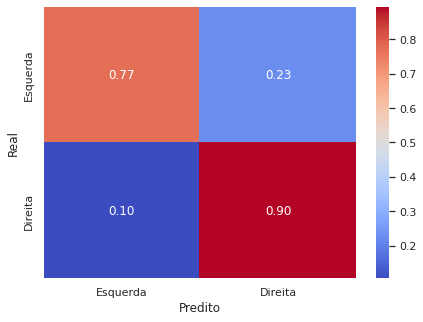

In [59]:
classification_with_svm(X, y, 'scale', 1, LeaveOneOut())